In [3]:
!pip install -q rouge_score transformers bert_score

In [1]:
import torch
from typing import List, Dict
from rouge_score import rouge_scorer, scoring
import bert_score
from transformers import AutoTokenizer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt


START_POPULATION='<pop>'
END_POPULATION='</pop>'
START_INTERVENTION='<int>'
END_INTERVENTION='</int>'
START_OUTCOME='<out>'
END_OUTCOME='</out>'
START_BACKGROUND = '<background>'
END_BACKGROUND = '</background>'
START_REFERENCE = '<ref>'
END_REFERENCE = '</ref>'
START_EVIDENCE = '<evidence>'
END_EVIDENCE = '</evidence>'
SEP_TOKEN = '<sep>'
EXTRA_TOKENS = [
    START_BACKGROUND,
    END_BACKGROUND,
    START_REFERENCE,
    END_REFERENCE,
    SEP_TOKEN,
    START_POPULATION,
    END_POPULATION,
    START_INTERVENTION,
    END_INTERVENTION,
    START_OUTCOME,
    END_OUTCOME,
    START_EVIDENCE,
    END_EVIDENCE,
]


def rouge_scores(
    preds: List[List[torch.Tensor]], targets: List[List[torch.Tensor]],
    tokenizer, use_stemmer=False, use_aggregator=False
):
    # largely copied from https://github.com/huggingface/nlp/blob/master/metrics/rouge/rouge.py#L84
    # and from https://github.com/allenai/ms2/blob/a03ab009e00c5e412b4c55f6ec4f9b49c2d8a7f6/ms2/models/utils.py
    rouge_types = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
    scorer = rouge_scorer.RougeScorer(rouge_types=rouge_types, use_stemmer=use_stemmer)
    refs, hyps = [], []
    for p, t in zip(preds, targets):
        assert len(p) == len(t)
        refs.extend(p)
        hyps.extend(t)

    if use_aggregator:
        aggregator = scoring.BootstrapAggregator()
        scores = None
    else:
        aggregator = None
        scores = []

    for ref, pred in zip(refs, hyps):
        if isinstance(ref, torch.Tensor):
            ref = tokenizer.decode(ref).lower()
        if isinstance(pred, torch.Tensor):
            pred = tokenizer.decode(pred).lower()
        score = scorer.score(ref, pred)
        if use_aggregator:
            aggregator.add_scores(score)
        else:
            scores.append(score)

    if use_aggregator:
        result = aggregator.aggregate()
    else:
        result = {}
        for key in scores[0]:
            result[key] = list(score[key] for score in scores)

    return result


def get_tokenizer(tokenizer_type: str):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_type, additional_special_tokens=EXTRA_TOKENS)
    return tokenizer


def calculate_rouge(targets: Dict[str, Dict], generated: Dict[str, str]) -> Dict:
    """
    Calculate ROUGE scores
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :return: dict of ROUGE scores (rouge1, rouge2, rougeL, rougeLsum)
    """
    # copied from https://github.com/allenai/mslr-shared-task/blob/c2218c1a440cf5172d784065b48af2d6c5c50f9a/evaluator/evaluator.py
    print("Computing ROUGE scores...")
    docids = list(targets.keys())
    target_texts = [[targets[docid]['target']] for docid in docids]
    generated_texts = [[generated.get(docid, '')] for docid in docids]

    # rouge scoring
    tokenizer = get_tokenizer('facebook/bart-base')
    rouge_results = rouge_scores(generated_texts, target_texts, tokenizer, use_aggregator=True)
    return rouge_results


def calculate_mid_rouge(targets: Dict[str, Dict], generated: Dict[str, str]) -> Dict:
    """
    Calculate ROUGE scores but only return mid fmeasure.
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :return: dict of ROUGE scores (rouge1, rouge2, rougeL, rougeLsum)
    """
    results = calculate_rouge(targets, generated)
    return {
        "rouge": results,
        "rouge1": results["rouge1"].mid.fmeasure,
        "rouge2": results["rouge2"].mid.fmeasure,
        "rougeL": results["rougeL"].mid.fmeasure,
        "rougeLsum": results["rougeLsum"].mid.fmeasure,
    }


def calculate_bertscore(
    targets: Dict[str, Dict], generated: Dict[str, str], model_type="roberta-large"
) -> Dict:
    """
    Calculate BERTscore
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :param model_type: model type for BERTscore. Choose from many choices (look
        up bert-score github). Note that MSLR/MS2 uses roberta-large in default
        args, but https://huggingface.co/allenai/led-base-16384-ms2 uses
        `microsoft/deberta-xlarge-mnli`. Note that `bert-score`
        recommends `microsoft/deberta-xlarge-mnli` as the one with best
        correlation with human judgement. Details here:
        https://huggingface.co/microsoft/deberta-xlarge-mnli
    :return: dict of BERTscore results (bs_ps, bs_rs, bs_fs) (precision, recall, f1)
    """
    # copied from https://github.com/allenai/mslr-shared-task/blob/c2218c1a440cf5172d784065b48af2d6c5c50f9a/evaluator/evaluator.py
    # original bert score: https://github.com/Tiiiger/bert_score
    print("Computing BERTscore...")
    docids = list(targets.keys())
    target_texts = [targets[docid]['target'] for docid in docids]
    generated_texts = [generated.get(docid, '') for docid in docids]

    # BERTscore
    bs_ps, bs_rs, bs_fs = bert_score.score(generated_texts, target_texts, model_type=model_type)
    return {
        "bs_ps": bs_ps,
        "bs_rs": bs_rs,
        "bs_fs": bs_fs
    }


def calculate_mean_bertscore(
    targets: Dict[str, Dict], generated: Dict[str, str], model_type="roberta-large"
) -> Dict:
    """
    Calculate mean BERTscore
    :param targets: dict of docid -> {'target': target_text}
    :param generated: dict of docid -> generated_text
    :param model_type: model type for BERTscore.
    :return: dict of mean BERTscore results (bs_ps, bs_rs, bs_fs) (precision, recall, f1)
    """
    individual_results = calculate_bertscore(targets, generated, model_type=model_type)

    results = {
        "bertscore_avg_p": torch.mean(individual_results["bs_ps"]).item(),
        "bertscore_avg_r": torch.mean(individual_results["bs_rs"]).item(),
        "bertscore_avg_f": torch.mean(individual_results["bs_fs"]).item(),
        "bertscore_std_p": torch.std(individual_results["bs_ps"]).item(),
        "bertscore_std_r": torch.std(individual_results["bs_rs"]).item(),
        "bertscore_std_f": torch.std(individual_results["bs_fs"]).item(),
    }
    return results


# pull in original validation data from huggingface datasets
dataset = load_dataset("allenai/mslr2022", "ms2", split="validation")  # takes 9 mins
display(dataset)

# organize target data into dicts for rouge and bertscore
targets = {row['review_id']: row for row in dataset}

Dataset({
    features: ['review_id', 'pmid', 'title', 'abstract', 'target', 'background'],
    num_rows: 2021
})

In [13]:
# Test with some toy examples

targets_toy = {
    "doc1": {"target": "The quick brown fox jumps over the lazy dog"},
    "doc2": {"target": "fruit flies like a banana"},
    "doc3": {"target": "fruit flies like a banana"},
    "doc4": {"target": "fruit flies like a banana"},
    "doc5": {"target": "everything is chaotic"},
    "doc6": {"target": "The quick brown fox jumps over the lazy dog"},
}

generated_toy = {
    "doc1": "A lazy dog is under a hopping speedy fox",  # synonym
    "doc2": "some insects are attracted to a yellow fruit",  # one interpretation
    "doc3": "most fruits have the aerodynamic properties of a banana",  # another interpretation
    "doc4": "nothing makes sense",  # completely irrelevant
    "doc5": "nothing makes sense",  # synonym
    "doc6": "The quick brown fox jumps over the lazy dog",  # perfect/identical
}

rouge_results = calculate_rouge(targets_toy, generated_toy)
display(rouge_results)

bertscore_results = calculate_bertscore(targets_toy, generated_toy, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge1': AggregateScore(low=Score(precision=0.12222222222222223, recall=0.0787037037037037, fmeasure=0.0989010989010989), mid=Score(precision=0.35555555555555557, recall=0.28703703703703703, fmeasure=0.31684981684981683), high=Score(precision=0.6333333333333333, recall=0.5972222222222222, fmeasure=0.6068376068376068)),
 'rouge2': AggregateScore(low=Score(precision=0.020833333333333332, recall=0.020833333333333332, fmeasure=0.020833333333333332), mid=Score(precision=0.20833333333333334, recall=0.20833333333333334, fmeasure=0.20833333333333334), high=Score(precision=0.5625, recall=0.5416666666666666, fmeasure=0.548611111111111)),
 'rougeL': AggregateScore(low=Score(precision=0.07407407407407407, recall=0.05787037037037037, fmeasure=0.07326007326007326), mid=Score(precision=0.30370370370370364, recall=0.26157407407407407, fmeasure=0.2716727716727717), high=Score(precision=0.5711111111111105, recall=0.5578703703703703, fmeasure=0.5626780626780626)),
 'rougeLsum': AggregateScore(low=Score

Computing BERTscore...


{'bs_ps': tensor([0.7381, 0.5301, 0.5480, 0.3825, 0.6740, 1.0000]),
 'bs_rs': tensor([0.7276, 0.5883, 0.6598, 0.4499, 0.6900, 1.0000]),
 'bs_fs': tensor([0.7328, 0.5577, 0.5987, 0.4135, 0.6819, 1.0000])}

In [33]:
# Test with some toy examples

targets_x_sample = {
    "28514886": {
        "target": "Current evidence from systematic review and meta- analysis revealed that probiotics are the most promising intervention in reduction of the incidence of NEC in VLBW neonates . As per the evidence , prebiotics modulate the composition of human intestine microflora to the benefit of the host by suppression of colonization of harmful microorganism and /or the stimulation of bifidobacterial growth , decreased stool viscosity , reduced gastrointestinal transit time , and better feed tolerance .",
        "background": targets["28514886"]["background"],
    },
    "18842808": {
        "target": "The use of glucomannan did not appear to significantly alter any other study endpoints . Pediatric patients , patients receiving dietary modification , and patients with impaired glucose metabolism did not benefit from glucomannan to the same degree . Glucomannan appears to beneficially affect total cholesterol , LDL cholesterol , triglycerides , body weight , and FBG , but not HDL cholesterol or BP",
        "background": targets["18842808"]["background"],
    },
}

generated_2_sample = {
    "28514886": "Retrieve concise conclusion without background: BACKGROUND : Necrotizing enterocolitis ( NEC ) is one of the most destructive diseases associated with the intestine. We aim to determine the effect of a preterm formula containing partially hydrolyzed whey protein, modified vegetable oil with a high & bgr;-palmitic acid content, on the intestinal flora. We hypothesized that enteral supplementation of a prebiotic mixture consisting of neutral oligosaccharides ( (SC)GOS/(LC)FOS ) and acidic oligosaccharides ( AOS ) on intestinal permeability. In a double-blind trial 20 preterm infants ( gestational age 27 ( 24 - 31 ) weeks, postnatal age 42 ( 11 - 84 ) days ), and weight at study entry 1570 ( 1080 - 2300 ) g were enrolled. The infants were randomized to receive either a formula with 8 g/L of either GOS/LCFOS ( 1.5 or 3.0 g/kg ). The stool specimens were quantitatively cultured weekly for the number of bifidobacteria, gastric residue, bowel habits, and feeding tolerance.  Clinical examination including anthropometric measurements, microbiological analysis of fecal sample s, and blood leukocyte population analysis were performed at birth and 6 and 10 weeks... The results showed that the incidence of NEC, the group fed the oligosaccharide supplemented formula increased to the upper range of infant growth, and the placebo group. The incidence of > or = 1 serious infection, as measured by extrusion force ( P=0.006 ), was not significantly different in the supplemented group ( P = 0.056 )..  The intestinal microbiota of infants who received a st and ard formula seems to resemble a more mature gut flora, while the 0.8 g/dL group, 9.7 - 14 % of these neonates.. Conclusion : Neonatal enteric NEC. The intestinal flora of preterm neonates was not different between the 2 groups. and/.}).",
    "18842808": "Retrieve concise conclusion without background: BACKGROUND The purpose of this study was to evaluate the effectiveness of the hydrosoluble fiber glucomannan to a Step-One-Diet in mildly hypercholesterolemic type II diabetic and non-diabetic subjects and to compare the response of these two subject groups to the treatments. MATERIAL / METHODS One hundred and seventy six men and women were included to receive either active fiber substance or placebo in r and omized placebo-controlled studies. The subjects were encouraged not to change their ordinary diets or general lifestyle during the investigation. RESULTS : After a three-days food recall, a balanced diet with adequate caloric intake was provided to all obese children. In all patients before and 2 - 4 months after the intervention, the plasma lipids ( weight, height, weight excess ) and laboratory data ( serum levels of cholesterol, HDL, triglycerides, glucose, fructosamine, glycosylated hemoglobin, RBC, WBC, hemoglobin, iron, calcium, Cu and Zn ) have been determined. Excess weight and triglycerids levels were significantly decreased in treated obese patients than in obese controls 4 months later. Both groups experienced decreases in ( P < 0.01 ) body weight, percent body fat, systolic blood pressure, waist circumference, and plasma glucose levels. After 12 weeks, HDL-C and TAG improved significantly in the fiber ( 10 % and -34 % ) and placebo ( 14 %, -43 % ) groups. The results of lipid profiles did not differ between subject groups. Overall plasma lathosterol concentrations, as well as FBG, and other lipids were lowered ( P<0.05 ). The study to perform a meta- analysis of r, omized controlled trials of glucarannan on plasma lipid, FBG.. and).-..",
}

rouge_results = calculate_mid_rouge(targets_2_sample, generated_2_sample)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets_2_sample, generated_2_sample, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.4727272727272727, recall=0.09961685823754789, fmeasure=0.16455696202531644), mid=Score(precision=0.4754940711462451, recall=0.10959103781442611, fmeasure=0.1779306549257017), high=Score(precision=0.4782608695652174, recall=0.11956521739130435, fmeasure=0.19130434782608696)),
  'rouge2': AggregateScore(low=Score(precision=0.08823529411764706, recall=0.019230769230769232, fmeasure=0.03184713375796178), mid=Score(precision=0.09041394335511982, recall=0.020524475524475526, fmeasure=0.033416278249243286), high=Score(precision=0.09259259259259259, recall=0.02181818181818182, fmeasure=0.03498542274052478)),
  'rougeL': AggregateScore(low=Score(precision=0.2727272727272727, recall=0.05747126436781609, fmeasure=0.0949367088607595), mid=Score(precision=0.2812911725955204, recall=0.06496751624187906, fmeasure=0.10543936892313338), high=Score(precision=0.2898550724637681, recall=0.07246376811594203, fmeasure=0.11594202898550726)),
  'rougeL

Computing BERTscore...


{'bertscore_avg_p': 0.47608551383018494,
 'bertscore_avg_r': 0.6032038927078247,
 'bertscore_avg_f': 0.5320615768432617,
 'bertscore_std_p': 0.006571114994585514,
 'bertscore_std_r': 0.014886646531522274,
 'bertscore_std_f': 0.0016888664104044437}

## Evaluating on model outputs

### BioBART

In [79]:
# Open results from BioBART on validation set
df_biobart = pd.read_csv("pretrained_no_finetune/biobart/biobart_validation.csv")
# review_id is the docid and should be a string
df_biobart['review_id'] = df_biobart['review_id'].astype(str)
display(df_biobart.head())

# organize into dicts for rouge and bertscore
generated_biobart = {row['review_id']: row['candidate'] for _, row in df_biobart.iterrows()}

# check to see if all docids are present and unique
assert set(generated_biobart.keys()) == set(targets.keys())
assert len(generated_biobart) == len(targets)

,review_id,candidate
0,26762372,Background : The aim of the present study was...
1,28723736,BACKGROUND Surgical site infections ( SSIs ) ...
2,22002191,BACKGROUND AND PURPOSE : The purpose of this ...
3,31921439,Background : Several established tools are av...
4,30301735,Background Topical glyceryl trinitrate ( GTN ...


<Axes: >

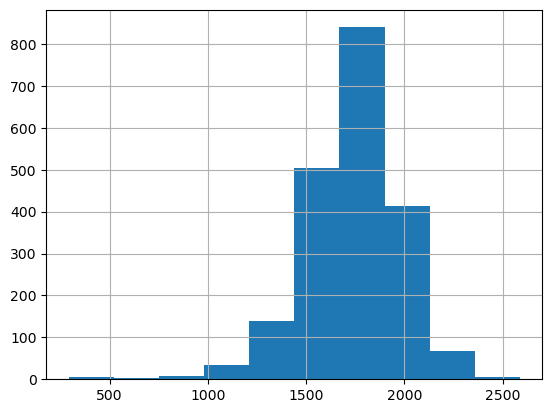

In [8]:
df_biobart.candidate.str.len().hist()

In [9]:
# SMALL SUBSET DATASET - calculate rouge and bertscore for only 10 docs

subset_review_ids = list(generated_biobart.keys())[:10]
targets_subset = {docid: targets[docid] for docid in subset_review_ids}
generated_subset = {docid: generated_biobart[docid] for docid in subset_review_ids}

rouge_results = calculate_mid_rouge(targets_subset, generated_subset)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets_subset, generated_subset, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.4085764548117969, recall=0.09217051335154197, fmeasure=0.1448897839623271), mid=Score(precision=0.46691416592132295, recall=0.1346856479283819, fmeasure=0.19092749741701748), high=Score(precision=0.5227113929191609, recall=0.18335498949362816, fmeasure=0.24417392291854567)),
  'rouge2': AggregateScore(low=Score(precision=0.07378749078582353, recall=0.019862255033613725, fmeasure=0.030216589670523743), mid=Score(precision=0.1241565192861693, recall=0.029366603129565398, fmeasure=0.042641450275991935), high=Score(precision=0.17737006675077563, recall=0.04004910719325335, fmeasure=0.05588984314531449)),
  'rougeL': AggregateScore(low=Score(precision=0.2140476538033701, recall=0.05383590357501683, fmeasure=0.08535759468459861), mid=Score(precision=0.2782796951002747, recall=0.07385370559083271, fmeasure=0.10569908603798697), high=Score(precision=0.349088778867628, recall=0.09313559353500153, fmeasure=0.12639377488587802)),
  'rougeL

Computing BERTscore...


{'bertscore_avg_p': 0.47950369119644165,
 'bertscore_avg_r': 0.5985714197158813,
 'bertscore_avg_f': 0.5301606059074402,
 'bertscore_std_p': 0.05009160935878754,
 'bertscore_std_r': 0.039970237761735916,
 'bertscore_std_f': 0.03192624822258949}

In [32]:
# FULL DATASET - calculate rouge and bertscore
rouge_results = calculate_mid_rouge(targets, generated_biobart)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets, generated_biobart, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.4961293110596966, recall=0.09804610749650168, fmeasure=0.15496854682493477), mid=Score(precision=0.5010460912997867, recall=0.10033882683006921, fmeasure=0.15787649150257704), high=Score(precision=0.5061464436016391, recall=0.10296259138737313, fmeasure=0.16123738642284913)),
  'rouge2': AggregateScore(low=Score(precision=0.12074097153798954, recall=0.021833711098443242, fmeasure=0.03501379734426587), mid=Score(precision=0.12477178207184145, recall=0.022547010164837327, fmeasure=0.03609727189353998), high=Score(precision=0.1284730654869281, recall=0.023239723047089753, fmeasure=0.03711046213471403)),
  'rougeL': AggregateScore(low=Score(precision=0.3091211111639237, recall=0.05700992858853988, fmeasure=0.09137477431435435), mid=Score(precision=0.3138483862064446, recall=0.05815324451429994, fmeasure=0.09277901738343573), high=Score(precision=0.31780643509315887, recall=0.059300800373725426, fmeasure=0.09430320248381381)),
  'rou

Computing BERTscore...


{'bertscore_avg_p': 0.4647563397884369,
 'bertscore_avg_r': 0.6073237061500549,
 'bertscore_avg_f': 0.524921178817749,
 'bertscore_std_p': 0.04064429923892021,
 'bertscore_std_r': 0.04167566075921059,
 'bertscore_std_f': 0.030336380004882812}

### LongT5

In [71]:
# Do the same for LongT5
df_longt5 = pd.read_csv("pretrained_no_finetune/longt5_validation_output.csv")
# rename columns
df_longt5.rename(columns={"ReviewID": "review_id", "Candidate_Summary": "candidate"}, inplace=True)
df_longt5['review_id'] = df_longt5['review_id'].astype(str)
display(df_longt5.head())

# organize into dicts for rouge and bertscore
generated_longt5 = {row['review_id']: row['candidate'] for _, row in df_longt5.iterrows()}

# check to see if all docids are present and unique
assert set(generated_longt5.keys()) == set(targets.keys())
assert len(generated_longt5) == len(targets)

,review_id,candidate,Target
0,28514886,"In this paper, the authors present a detailed ...",Current evidence from systematic review and me...
1,18842808,The effects of soluble fiber Konjacglucomannaa...,The use of glucomannan did not appear to signi...
2,24297836,"In this study, we examine the autonomic functi...",Ensuring that the characteristics of the histo...
3,32367221,The first four months after ACL-reconstruction...,The QT autograft detected comparable rate of L...
4,25038833,"In this study, we examine the effects of a com...",medicines with anti-cholinergic properties hav...


<Axes: >

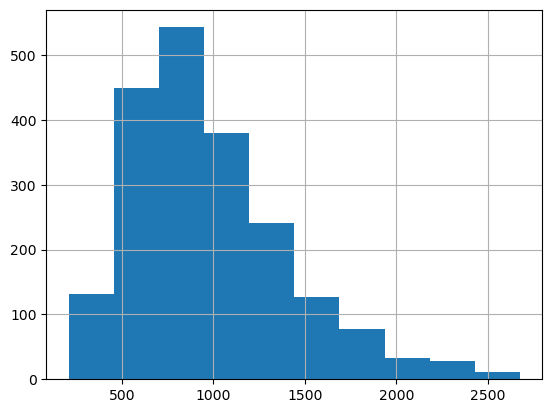

In [15]:
df_longt5.candidate.str.len().hist()

In [21]:
# FULL DATASET - calculate rouge and bertscore
rouge_results = calculate_mid_rouge(targets, generated_longt5)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets, generated_longt5, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.3689880935169033, recall=0.1373716882683111, fmeasure=0.18146408062581565), mid=Score(precision=0.37411828801996916, recall=0.1409145648626524, fmeasure=0.18470632255173647), high=Score(precision=0.3794242086017666, recall=0.14449596274682863, fmeasure=0.1879584466757623)),
  'rouge2': AggregateScore(low=Score(precision=0.04557487872639194, recall=0.01590814686224898, fmeasure=0.021231856485365564), mid=Score(precision=0.04793996144557606, recall=0.016668281522408682, fmeasure=0.0221177594000776), high=Score(precision=0.050202056518269936, recall=0.017373962287074943, fmeasure=0.022961333533190822)),
  'rougeL': AggregateScore(low=Score(precision=0.21965267778396885, recall=0.07783630907778631, fmeasure=0.10407646651699773), mid=Score(precision=0.22360079833164628, recall=0.07955625729090238, fmeasure=0.105555116591603), high=Score(precision=0.22757073587894702, recall=0.08141784681695725, fmeasure=0.10705688532393431)),
  'roug

Computing BERTscore...


{'bertscore_avg_p': 0.511027991771698,
 'bertscore_avg_r': 0.5844007730484009,
 'bertscore_avg_f': 0.5434643030166626,
 'bertscore_std_p': 0.04310934618115425,
 'bertscore_std_r': 0.048223260790109634,
 'bertscore_std_f': 0.033570773899555206}

In [80]:
# Do the same for Pegasus

df_pegasus = pd.read_csv("PEGASUS_LARGE/val-prediction.csv", index_col=0).reset_index(drop=True)
df_pegasus.rename(columns={"Summary": "candidate"}, inplace=True)
df_pegasus['review_id'] = df_pegasus['review_id'].astype(str)
display(df_pegasus.head())

# organize into dicts for rouge and bertscore
generated_pegasus = {row['review_id']: row['candidate'] for _, row in df_pegasus.iterrows()}
# check to see if all docids are present and unique
assert set(generated_pegasus.keys()) == set(targets.keys())
assert len(generated_pegasus) == len(targets)

,review_id,candidate
0,28514886,The 5′ nuclease assays were subsequently used ...
1,18842808,GM fibers reduced total cholesterol ( TC ) con...
2,24297836,The purpose of this study was 1 ) to evaluate ...
3,32367221,"Pain on kneeling, KT-1000 measured side to sid..."
4,25038833,RESULTS Results of the Name-Face Association T...


<Axes: >

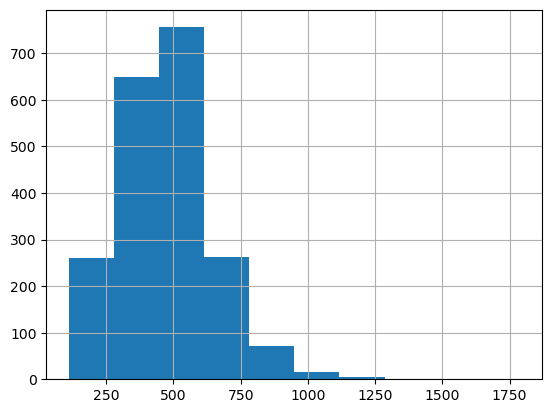

In [30]:
df_pegasus.candidate.str.len().hist()

In [31]:
# FULL DATASET - calculate rouge and bertscore
rouge_results = calculate_mid_rouge(targets, generated_pegasus)
display(rouge_results)

bertscore_results = calculate_mean_bertscore(targets, generated_pegasus, "microsoft/deberta-xlarge-mnli")
display(bertscore_results)

Computing ROUGE scores...


{'rouge': {'rouge1': AggregateScore(low=Score(precision=0.23188510954639052, recall=0.16099073832364824, fmeasure=0.17069165533548553), mid=Score(precision=0.23636549568618445, recall=0.16508845641785155, fmeasure=0.17369981891498523), high=Score(precision=0.2410069773924332, recall=0.16849743182924395, fmeasure=0.17653612736981214)),
  'rouge2': AggregateScore(low=Score(precision=0.025609972888597017, recall=0.016841790228365836, fmeasure=0.018114094286240737), mid=Score(precision=0.027286249022990428, recall=0.01787230488805157, fmeasure=0.01910065539440901), high=Score(precision=0.028971208429477726, recall=0.01883083674581007, fmeasure=0.020115374285278053)),
  'rougeL': AggregateScore(low=Score(precision=0.14984277944496277, recall=0.10096691095688277, fmeasure=0.10783642394171626), mid=Score(precision=0.1529523009446699, recall=0.10302738727799489, fmeasure=0.10937489929608912), high=Score(precision=0.15617329592365214, recall=0.10519244319098883, fmeasure=0.11108952315261846)),


Computing BERTscore...


{'bertscore_avg_p': 0.4978368282318115,
 'bertscore_avg_r': 0.5536131858825684,
 'bertscore_avg_f': 0.5221330523490906,
 'bertscore_std_p': 0.05015239864587784,
 'bertscore_std_r': 0.057531993836164474,
 'bertscore_std_f': 0.042330335825681686}

## Delta Evidence Inference

In [10]:
# Run this once to get EI model params
!cd evaluator/ && wget https://ai2-s2-ms2.s3-us-west-2.amazonaws.com/evidence_inference_models.zip  # For Linux
# !cd evaluator/ && curl -O https://ai2-s2-ms2.s3-us-west-2.amazonaws.com/evidence_inference_models.zip  # For MacOS if there's no wget
!cd evaluator/ && unzip -q evidence_inference_models.zip

In [75]:
# Delta Evidence Inference
# From MSLR repo
import os
import json
import torch
from typing import Dict
from importlib import reload
import random

from evaluator import evaluator


# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# also consider mps
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.set_device(0)
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')


def calculate_evidence_inference_divergence(
        targets: Dict[str, Dict],
        generated: Dict[str, str],
        ei_param_file: str,
        ei_model_dir: str,
        ei_use_unconditional: bool = False
) -> Dict:
    """
    Calculate Evidence Inference Divergence
    :param targets: dict of docid -> {'target': target_text , 'preface': preface_text}
    :param generated: dict of docid -> generated_text
    :param ei_param_file: path to json file containing EI model parameters
    :param ei_model_dir:
    :param ei_use_unconditional:
    :return:
    """
    print("Computing Delta Evidence Inference scores...")
    docids = list(targets.keys())
    target_texts = [targets[docid]['target'] for docid in docids]
    preface_texts = [targets[docid]['preface'] for docid in docids]
    generated_texts = [generated.get(docid, '') for docid in docids]

    generated_texts = list(map(evaluator.clean, generated_texts))
    target_texts = list(map(evaluator.clean, target_texts))

    # evidence inference scoring
    with open(ei_param_file, 'r') as inf:
        params = json.loads(inf.read())
    _, evidence_inference_classifier, _, _, _, evidence_inference_tokenizer = evaluator.initialize_models(params)
    if ei_use_unconditional:
        classifier_file = os.path.join(
            ei_model_dir,
            'unconditioned_evidence_classifier',
            'unconditioned_evidence_classifier.pt'
        )
    else:
        classifier_file = os.path.join(
            ei_model_dir, 'evidence_classifier', 'evidence_classifier.pt'
        )

    # pooler parameters are added by default in an older transformers, so we have to ignore that those are uninitialized.
    evidence_inference_classifier.load_state_dict(
        torch.load(classifier_file, map_location=device), strict=False
    )
    if torch.cuda.is_available():
        evidence_inference_classifier.cuda()
    elif torch.backends.mps.is_available():
        evidence_inference_classifier.to(device)

    entailment_results = evaluator.entailment_scores(
        evidence_inference_classifier, evidence_inference_tokenizer,
        generated_texts, target_texts, preface_texts,
        use_ios=ei_use_unconditional
    )

    return entailment_results

In [77]:
# Test usage on toy examples
reload(evaluator)

some_targets = ["significant improvements are found", "treatment is definitely not helpful", "no significant results are found"]
a_generic_preface = "studying this is important"

# modify targets_toy to include preface (key "background", value "this is a test")
num_examples = 10

targets_toy_2 = {
    doc_key: {
        "target": random.choice(some_targets),
        "preface": a_generic_preface,
    } for doc_key in range(num_examples)
}
generated_toy_2 = {
    doc_key: random.choice(some_targets) for doc_key in range(num_examples)
}

# test usage
results_toy = calculate_evidence_inference_divergence(
    targets_toy_2,
    generated_toy_2,
    "evaluator/bert_pipeline_8samples.json",
    "evaluator/evidence_inference_models",
)
# print everything except the raw scores
for key, val in results_toy.items():
    if key != "scores":
        display(key, val)

# Compare scores and target-generated pairs in a dataframe
df_toy = pd.DataFrame({
    "docid": list(targets_toy_2.keys()),
    "target": [targets_toy_2[docid]["target"] for docid in targets_toy_2.keys()],
    "generated": [generated_toy_2[docid] for docid in generated_toy_2.keys()],
    "score": list(results_toy["scores"]),
})
display(df_toy)

Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'average'

0.19373307094613526

'std'

0.30078610414331475

'uniform_preds'

0.46051702656047766

'f1_score'

{'significantly decreased': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 0.0},
 'no significant difference': {'precision': 0.8888888888888888,
  'recall': 1.0,
  'f1-score': 0.9411764705882353,
  'support': 8.0},
 'significantly increased': {'precision': 1.0,
  'recall': 0.5,
  'f1-score': 0.6666666666666666,
  'support': 2.0},
 'micro avg': {'precision': 0.9,
  'recall': 0.9,
  'f1-score': 0.9,
  'support': 10.0},
 'macro avg': {'precision': 0.6296296296296297,
  'recall': 0.5,
  'f1-score': 0.5359477124183006,
  'support': 10.0},
 'weighted avg': {'precision': 0.9111111111111111,
  'recall': 0.9,
  'f1-score': 0.8862745098039216,
  'support': 10.0}}

,docid,target,generated,score
0,0,no significant results are found,no significant results are found,0.000000
1,1,treatment is definitely not helpful,no significant results are found,0.315579
2,2,treatment is definitely not helpful,treatment is definitely not helpful,0.000000
3,3,treatment is definitely not helpful,no significant results are found,0.315579
4,4,no significant results are found,no significant results are found,0.000000
5,5,significant improvements are found,significant improvements are found,0.000000
6,6,treatment is definitely not helpful,no significant results are found,0.315579
7,7,significant improvements are found,no significant results are found,0.990595
8,8,treatment is definitely not helpful,treatment is definitely not helpful,0.000000
9,9,treatment is definitely not helpful,treatment is definitely not helpful,0.000000


In [78]:
# Test on X sample docs
generated_candidates_to_use = generated_longt5
# num_examples = 100
num_examples = len(generated_candidates_to_use)  # to get all examples

targets_x_sample = {
    doc_key: {
        "target": targets[doc_key]["target"],
        "preface": targets[doc_key]["background"],
    } for doc_key in list(targets.keys())[:num_examples]
}
generated_x_sample = {
    doc_key: generated_candidates_to_use[doc_key] for doc_key in targets_x_sample.keys()
}
results_x_sample = calculate_evidence_inference_divergence(
    targets_x_sample,
    generated_x_sample,
    "evaluator/bert_pipeline_8samples.json",
    "evaluator/evidence_inference_models",
)

# print everything except the raw scores
for key, val in results_x_sample.items():
    if key != "scores":
        display(key, val)

# Compare scores and target-generated pairs in a dataframe
df_x_sample = pd.DataFrame({
    "docid": list(targets_x_sample.keys()),
    "target": [targets_x_sample[docid]["target"] for docid in targets_x_sample.keys()],
    "generated": [generated_x_sample[docid] for docid in generated_x_sample.keys()],
    "score": list(results_x_sample["scores"]),
})
display(df_x_sample.sample(10))

# save results to csv
df_x_sample.to_csv("evaluator/evidence_inference_results_longt5.csv", index=False)

Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


'average'

0.5432441385412898

'std'

0.39463136145671507

'uniform_preds'

0.5406478590360975

'f1_score'

{'significantly decreased': {'precision': 0.09401709401709402,
  'recall': 0.1981981981981982,
  'f1-score': 0.127536231884058,
  'support': 111.0},
 'no significant difference': {'precision': 0.639599555061179,
  'recall': 0.47364085667215816,
  'f1-score': 0.5442498816848084,
  'support': 1214.0},
 'significantly increased': {'precision': 0.375,
  'recall': 0.47844827586206895,
  'f1-score': 0.42045454545454547,
  'support': 696.0},
 'accuracy': 0.46016823354774866,
 'macro avg': {'precision': 0.369538883026091,
  'recall': 0.3834291102441418,
  'f1-score': 0.3640802196744706,
  'support': 2021.0},
 'weighted avg': {'precision': 0.518510518198995,
  'recall': 0.46016823354774866,
  'f1-score': 0.4787294615244193,
  'support': 2021.0}}

,docid,target,generated,score
1376,28668150,( S ) Few studies of medical therapies for end...,"In this study, the effects of continuous or cy...",0.019503
15,28616252,Our case study successfully enabled us to addr...,"This paper focuses on pilot studies, or ""feasi...",0.504117
329,30921478,Two primary outcomes of efficacy and acceptabi...,A double blind trial of a combination of alpra...,0.006196
76,10796152,REVIEW ER 'S CONCLUSIONS Iodine supplementatio...,"In this study, the effects of reduced maternal...",0.485056
77,26897342,"Among children , these interventions demonstra...","The Switch program is a novel, evidence-based ...",0.983839
727,28898559,"Physical activity did not change at 6 months ,...","In this study, we examine the efficacy of a lo...",0.846085
515,29279934,Subgroup analyses showed that these results we...,This study focuses on the effects of four-mont...,0.110708
979,30985692,Results : This systematic review will provide ...,"In this study, the combined efficaciousness of...",0.452037
1760,26081915,The findings support the effects of BAs on sat...,Gastric bypass is an effective treatment for T...,0.983107
1549,25978537,Reflecting public health interest in the poten...,"In this study, we examine the effects of a six...",0.088469


In [74]:
import pprint

# What's actually happening?
# find the docid with the highest score
print("Highest score: (higher is bad)")
pprint.pprint(df_x_sample.sort_values(by="score", ascending=False).head(1).to_dict(orient="records"))

# find the docid with the lowest score
print("Lowest score: (lower is good)")
pprint.pprint(df_x_sample.sort_values(by="score", ascending=True).head(1).to_dict(orient="records"))

Highest score: (higher is bad)
[{'docid': '25076495',
  'generated': "The Nurses' Health Study, a large cohort study of women aged "
               '52-77 years, records the consumption of walnuts in relation to '
               'risk of type two diabetes. In this paper, we report that there '
               'is a significant lower risk of Type 2 disease in women who '
               'consume more than 1 serving per day. Women who do not '
               'frequently consume walnuts are also associated with an '
               'increased risk of developing type 2 disease. We conclude that '
               'higher nuts have a protective effect on both blood lipid and '
               'body weight because they improve insulin sensitivity. A diet '
               'rich in fat but low in carbohydrates has been shown to be '
               'effective in improving many modifiably important '
               'cardiovascular risk factors. Almond was found to be superior '
               'to othe

In [83]:
# Wrap in a loop

model_results = {}
for model_name, generated_candidates_to_use in [
    ("BioBART", generated_biobart),
    ("LongT5", generated_longt5),
    ("Pegasus", generated_pegasus),
]:
    print(f"\n\n##### Running {model_name} #####")
    num_examples = len(generated_candidates_to_use)  # to get all examples

    targets_x_sample = {
        doc_key: {
            "target": targets[doc_key]["target"],
            "preface": targets[doc_key]["background"],
        } for doc_key in list(targets.keys())[:num_examples]
    }
    generated_x_sample = {
        doc_key: generated_candidates_to_use[doc_key] for doc_key in targets_x_sample.keys()
    }
    results_x_sample = calculate_evidence_inference_divergence(
        targets_x_sample,
        generated_x_sample,
        "evaluator/bert_pipeline_8samples.json",
        "evaluator/evidence_inference_models",
    )
    model_results[model_name] = {}
    model_results[model_name]["results"] = results_x_sample

    # print everything except the raw scores
    for key, val in results_x_sample.items():
        if key != "scores":
            display(key, val)

    # Compare scores and target-generated pairs in a dataframe
    df_x_sample = pd.DataFrame({
        "docid": list(targets_x_sample.keys()),
        "target": [targets_x_sample[docid]["target"] for docid in targets_x_sample.keys()],
        "generated": [generated_x_sample[docid] for docid in generated_x_sample.keys()],
        "score": list(results_x_sample["scores"]),
    })
    model_results[model_name]["df"] = df_x_sample
    display(df_x_sample.sample(10))

    # save results to csv
    df_x_sample.to_csv(f"evaluator/evidence_inference_results_{model_name.lower()}.csv", index=False)



##### Running BioBART #####
Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


'average'

0.5255207930010092

'std'

0.4020220675361712

'uniform_preds'

0.5406478590360975

'f1_score'

{'significantly decreased': {'precision': 0.08045977011494253,
  'recall': 0.1891891891891892,
  'f1-score': 0.11290322580645161,
  'support': 111.0},
 'no significant difference': {'precision': 0.6424682395644283,
  'recall': 0.5831960461285008,
  'f1-score': 0.61139896373057,
  'support': 1214.0},
 'significantly increased': {'precision': 0.3829787234042553,
  'recall': 0.3620689655172414,
  'f1-score': 0.3722304283604136,
  'support': 696.0},
 'accuracy': 0.48540326571004455,
 'macro avg': {'precision': 0.3686355776945421,
  'recall': 0.37815140027831046,
  'f1-score': 0.36551087263247845,
  'support': 2021.0},
 'weighted avg': {'precision': 0.5222368475028879,
  'recall': 0.48540326571004455,
  'f1-score': 0.5016541208175537,
  'support': 2021.0}}

,docid,target,generated,score
1543,31616340,The results confirmed the presence of a relati...,OBJECTIVE Cognitive dysfunction is an increas...,0.017790
282,25271203,This systematic review covered all the relevan...,Study Design. A cross-sectional study compari...,0.120460
999,16983542,Results There is some evidence of the effectiv...,OBJECTIVE To examine whether risperidone is e...,0.986373
67,26104189,Conclusion These studies provide preliminary e...,Background The purpose of this study was to c...,0.919738
229,19300334,Although current guidelines for antibiotic pro...,OBJECTIVE To determine the efficacy of the ad...,0.996130
673,25831962,The review demonstrated that the WHO-5 has hig...,BACKGROUND : The point prevalence of depressi...,0.844074
550,16508562,Robust statistically significant effects were ...,We compared the effects of nonpharmacological...,0.077446
1298,24772264,The best retention capacity of the material in...,BACKGROUND The aim of this study was to compa...,0.962021
1747,32187830,Circulating fasting total BA was not associate...,BACKGROUND Bile acids ( BAs ) are currently n...,0.793408
1653,25429224,Vertebral fracture caused the greatest health ...,BACKGROUND BACKGROUND Vertebral fractures are...,0.448402




##### Running LongT5 #####
Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


'average'

0.5432441385412898

'std'

0.39463136145671507

'uniform_preds'

0.5406478590360975

'f1_score'

{'significantly decreased': {'precision': 0.09401709401709402,
  'recall': 0.1981981981981982,
  'f1-score': 0.127536231884058,
  'support': 111.0},
 'no significant difference': {'precision': 0.639599555061179,
  'recall': 0.47364085667215816,
  'f1-score': 0.5442498816848084,
  'support': 1214.0},
 'significantly increased': {'precision': 0.375,
  'recall': 0.47844827586206895,
  'f1-score': 0.42045454545454547,
  'support': 696.0},
 'accuracy': 0.46016823354774866,
 'macro avg': {'precision': 0.369538883026091,
  'recall': 0.3834291102441418,
  'f1-score': 0.3640802196744706,
  'support': 2021.0},
 'weighted avg': {'precision': 0.518510518198995,
  'recall': 0.46016823354774866,
  'f1-score': 0.4787294615244193,
  'support': 2021.0}}

,docid,target,generated,score
896,27071989,Although the convergent validity of ImPACT was...,Brain injury is a common cause of concusions i...,0.888612
313,22354262,Antihypertensive drugs reduce headache but it ...,The effect of an anti-hyptertensive drug on me...,0.320313
1117,20824372,Conclusions P-POSSUM was the most accurate mod...,"In this paper, Dr. Manette focuses on the use ...",0.128728
1601,28700715,"At the class level , behavioural therapy ( alo...","In this paper, the authors describe a doublebl...",0.962361
1476,31833645,"However , total PA , sedentary behaviour , and...","In this paper, we identify the most important ...",0.998453
1955,25370201,"Motor fitness , particularly balance , was the...","In this study, we examine the effect of an int...",0.993318
1608,28720391,EVIDENCE SYNTHESIS The systematic review showe...,"In this study, we report the effcacy and safet...",0.419093
1850,28025174,R and omized controlled trials found a positiv...,The effect of moderate- to-vigorously intensit...,0.951206
1986,26210195,Conclusions RYGB surgery reverses the dyslipid...,The effect of statin therapy on the reduction ...,0.451245
1976,30547275,The evidence supports the WPAI as having test-...,"In this study, we examine the effect of four-g...",0.514672




##### Running Pegasus #####
Computing Delta Evidence Inference scores...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at allenai/biomed_roberta_base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


'average'

0.5584327999499968

'std'

0.3984307240017028

'uniform_preds'

0.5406478590360975

'f1_score'

{'significantly decreased': {'precision': 0.08873720136518772,
  'recall': 0.23423423423423423,
  'f1-score': 0.12871287128712872,
  'support': 111.0},
 'no significant difference': {'precision': 0.6457564575645757,
  'recall': 0.43245469522240526,
  'f1-score': 0.5180069067587568,
  'support': 1214.0},
 'significantly increased': {'precision': 0.3825136612021858,
  'recall': 0.5028735632183908,
  'f1-score': 0.4345127250155183,
  'support': 696.0},
 'accuracy': 0.4458189015338941,
 'macro avg': {'precision': 0.3723357733773163,
  'recall': 0.3898541642250101,
  'f1-score': 0.3604108343538013,
  'support': 2021.0},
 'weighted avg': {'precision': 0.5245065200552459,
  'recall': 0.4458189015338941,
  'f1-score': 0.46787153395784403,
  'support': 2021.0}}

,docid,target,generated,score
383,25754617,We found high quality evidence that hormone th...,A decrease in both vaginal pH ( P less than 0....,0.202884
985,25187795,"Therefore , the rotary NiTi Hero 642 and K3 fi...",CONCLUSION Hero rotary instruments produced mo...,0.043736
1845,24405725,We found a strong level of evidence for a rela...,RESULTS Of those who participated in a r and o...,0.345374
660,28488799,Endurance training alone was found to increase...,Multivariate analysis ( 95%CI ) in all three p...,0.997671
1887,27714911,"Group sports improve body composition , cardio...",Compared with children receiving health educat...,0.980351
958,29119235,Subgroup analysis suggested the existence of l...,The following variables were assessed at 4 ( b...,0.990305
205,29453672,Conclusion Plant and marine sources of n-3 PUF...,The direct effects of PUFA on leptin promoter ...,0.879165
1302,26605535,CONCLUSION Lateral wedge insoles cause small r...,Results of this study suggest that using a cus...,0.517784
1768,28034901,Conclusions : Obesity is associated with lower...,"In contrast, BMI was not associated with five-...",0.957437
113,21339335,RhGh did not consistently affect blood pressur...,"In the GH-treated group only, a low baseline G...",0.993109


## Running Evaluation in Bulk

In [113]:
from importlib import reload
import pickle
import os
from pprint import pprint

import pandas as pd
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt

from evaluator import evaluator

reload(evaluator)


# organize all instance of generated text: model_name, path, column_for_generated_text, column_for_review_id
model_results_info = {
    "Baseline abstractive bioBART": ("pretrained_no_finetune/biobart/biobart_validation.csv", "candidate", "review_id"),
    "Baseline abstractive Longt5": ("pretrained_no_finetune/longt5_validation_output.csv", "Candidate_Summary", "ReviewID"),
    "Baseline abstractive Pegasus": ("abstractive_model/pegasus-val-prediction.csv", "Summary", "review_id"),

    # "Baseline extractive BERT KMeans OLD": ("baseline_extractive/BERT_extractive_prediction.csv", "summary", "review_id"),
    # "Baseline extractive BioBERT KMeans OLD": ("baseline_extractive/BioBERT_extractive_prediction.csv", "summary", "review_id"),
    # "Baseline extractive SciBERT KMeans OLD": ("baseline_extractive/SciBERT_extractive_prediction.csv", "summary", "review_id"),
    # "Baseline_extractive_biobert_OLD": ("experiment_1/BioBERT_K_Means_extractive.csv", "summary", "review_id"),

    "Baseline extractive BioBERT KMeans": ("extractive_models/BioBERT_Kmeans_extractive.csv", "summary", "review_id"),
    "Baseline extractive SciBERT KMeans": ("extractive_models/SciBERT_Kmeans_extractive.csv", "summary", "review_id"),
    "Baseline extractive BERT KMeans": ("extractive_models/BERT_Kmeans_extractive.csv", "summary", "review_id"),

    "Experiment 1 BioBERT KMeans + LongT5": ("experiment_1/summaries/summary_BioBERT_K_Means_Long_T5_prediction.csv", "Summary", "review_id"),
    "Experiment 2 BioBERT HDBSCAN + LongT5": ("experiment_2/summaries/summary_BioBERT_HDBSCAN_UMAP_Long_T5_prediction.csv", "Summary", "review_id"),
    "Experiment 3 Rules-based extraction + LongT5": ("extraction_exploration/results_longt5_conclusion_only/longt5_with_conclusion_only_validation.csv", "candidate", "review_id"),

    "Experiment 4 LongT5, full fine-tuning, epoch 8, full input": ("experiment_4_full_finetune/model_evaluation_output_epoch-8-train-loss-2.0239-val-loss-2.6407.csv", "Candidate_Summary", "review_id"),  # train: full, inference: full
    "Experiment 4 LongT5, full fine-tuning, epoch 9, full input": ("experiment_4_full_finetune/model_evaluation_output_epoch-9-train-loss-1.9464-val-loss-2.6663.csv", "Candidate_Summary", "review_id"),  # train: full, inference: full
    "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, full input": ("experiment_4_full_finetune/model_evaluation_output_Kmeans_finetuned_simplet5-epoch-7-train-loss-2.1058-val-loss-2.5727.csv", "Candidate_Summary", "review_id"),
    "Experiment 4 LongT5, full fine-tuning, KMeans input": ("experiment_4_full_finetune/Regular_fineTuend_Kmeans_input_validation.csv", "Candidate_Summary", "review_id"),
    "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input": ("experiment_4_full_finetune/Kmeans_fineTuend_Kmeans_input_validation.csv", "Candidate_Summary", "review_id"),

    "Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning": ("experiment_5_peft/training_history/generated_summaries.csv", "summary", "review_id"),
}

# reshape into a dataframe
df_model_info = pd.DataFrame({
    "model_name": list(model_results_info.keys()),
    "generated_summaries_path": [info[0] for info in model_results_info.values()],
    "column_for_generated_text": [info[1] for info in model_results_info.values()],
    "column_for_review_id": [info[2] for info in model_results_info.values()],
})
# create results save name: lowercase of name, replace spaces with underscores
df_model_info["results_save_name"] = df_model_info["model_name"].str.lower().str.replace(" ", "_").str.replace(",", "").str.replace("+", "plus")

# ensure all model_name and results_save_name are unique
assert len(df_model_info) == len(df_model_info["model_name"].unique())
assert len(df_model_info) == len(df_model_info["results_save_name"].unique())
display(df_model_info)

,model_name,generated_summaries_path,column_for_generated_text,column_for_review_id,results_save_name
0,Baseline abstractive bioBART,pretrained_no_finetune/biobart/biobart_validat...,candidate,review_id,baseline_abstractive_biobart
1,Baseline abstractive Longt5,pretrained_no_finetune/longt5_validation_outpu...,Candidate_Summary,ReviewID,baseline_abstractive_longt5
2,Baseline abstractive Pegasus,abstractive_model/pegasus-val-prediction.csv,Summary,review_id,baseline_abstractive_pegasus
3,Baseline extractive BioBERT KMeans,extractive_models/BioBERT_Kmeans_extractive.csv,summary,review_id,baseline_extractive_biobert_kmeans
4,Baseline extractive SciBERT KMeans,extractive_models/SciBERT_Kmeans_extractive.csv,summary,review_id,baseline_extractive_scibert_kmeans
5,Baseline extractive BERT KMeans,extractive_models/BERT_Kmeans_extractive.csv,summary,review_id,baseline_extractive_bert_kmeans
6,Experiment 1 BioBERT KMeans + LongT5,experiment_1/summaries/summary_BioBERT_K_Means...,Summary,review_id,experiment_1_biobert_kmeans_plus_longt5
7,Experiment 2 BioBERT HDBSCAN + LongT5,experiment_2/summaries/summary_BioBERT_HDBSCAN...,Summary,review_id,experiment_2_biobert_hdbscan_plus_longt5
8,Experiment 3 Rules-based extraction + LongT5,extraction_exploration/results_longt5_conclusi...,candidate,review_id,experiment_3_rules-based_extraction_plus_longt5
9,"Experiment 4 LongT5, full fine-tuning, epoch 8...",experiment_4_full_finetune/model_evaluation_ou...,Candidate_Summary,review_id,experiment_4_longt5_full_fine-tuning_epoch_8_f...


In [112]:
# if eval was already done, and the pkl file exists, copy and rename to the right file name

destination_folder = "evaluator/results"
for _, row in df_model_info.iterrows():
    old_eval_name = os.path.join(destination_folder, f"{row['generated_summaries_path'].split('.csv')[0].split('/')[-1]}.pkl")
    new_eval_name = os.path.join(destination_folder, f"{row['results_save_name']}.pkl")

    if os.path.exists(new_eval_name):
        print(f"🟢 {new_eval_name} already exists")
    elif os.path.exists(old_eval_name):
        !cp $old_eval_name $new_eval_name
        print(f"🟢 Copied {old_eval_name} to {new_eval_name}")
    elif os.path.exists(row['generated_summaries_path']):
        print(f"🟡 File {old_eval_name} does not exist, but its generated summaries file does. Requires eval")
    else:
        print(f"💔 Neither {old_eval_name} nor {row['generated_summaries_path']} exists")


🟡 File evaluator/results/biobart_validation.pkl does not exist, but its generated summaries file does. Requires eval
🟡 File evaluator/results/longt5_validation_output.pkl does not exist, but its generated summaries file does. Requires eval
🟡 File evaluator/results/pegasus-val-prediction.pkl does not exist, but its generated summaries file does. Requires eval
🟢 evaluator/results/baseline_extractive_biobert_kmeans.pkl already exists
🟢 evaluator/results/baseline_extractive_scibert_kmeans.pkl already exists
🟢 evaluator/results/baseline_extractive_bert_kmeans.pkl already exists
🟢 evaluator/results/experiment_1_biobert_kmeans_plus_longt5.pkl already exists
🟢 evaluator/results/experiment_2_biobert_hdbscan_plus_longt5.pkl already exists
🟢 evaluator/results/experiment_3_rules-based_extraction_plus_longt5.pkl already exists
🟢 evaluator/results/experiment_4_longt5_full_fine-tuning_epoch_8_full_input.pkl already exists
🟢 evaluator/results/experiment_4_longt5_full_fine-tuning_epoch_9_full_input.pkl

In [244]:
ev = evaluator.MS2Evaluator()
destination_folder = "evaluator/results"

metrics_completion_check = {
    "rouge": ["rouge"],
    "bertscore": ['bertscore_avg_f1', 'bertscore_avg_precision', 'bertscore_avg_recall', 'bertscore_f1s', 'bertscore_precisions', 'bertscore_recalls', 'bertscore_std_f1', 'bertscore_std_precision', 'bertscore_std_recall'],
    "evidence_inference_divergence": ['evidence_inference_divergence'],
}


for model_row in df_model_info.itertuples():
    generated_csv_source = model_row.generated_summaries_path
    candidate_key = model_row.column_for_generated_text
    review_id_key = model_row.column_for_review_id
    results_save_name = model_row.results_save_name

    print(f"\n\n##### Running {model_row.model_name} #####")

    df = pd.read_csv(generated_csv_source)

    if len(df) != 2021:
        print(f"🚨 {generated_csv_source} has {len(df)} examples, not 2021! Cannot evaluate")
        continue

    metrics_to_compute = list(metrics_completion_check.keys())

    # if results have been saved and metrics are complete, skip
    if os.path.exists(os.path.join(destination_folder, f"{results_save_name}.pkl")):
        with open(os.path.join(destination_folder, f"{results_save_name}.pkl"), "rb") as f:
            results_from_ev = pickle.load(f)

        # check if all metrics are present
        incomplete_metrics = []

        for metric_type, metric_list in metrics_completion_check.items():
            if not all([metric in results_from_ev for metric in metric_list]):
                incomplete_metrics.append(metric_type)

        # HACK: rerun ROUGE for selected models
        if results_save_name == "":
            incomplete_metrics = ["rouge"]

        if len(incomplete_metrics) == 0:
            # also check if the number of examples is the same
            if len(results_from_ev["bertscore_f1s"]) != len(df):
                print(f"🟡 {results_save_name} already exists but has different number of examples. Requires full eval")
            else:
                print(f"⏭️ {results_save_name} already exists and metrics are complete. Skipping")
                continue

        else:
            # otherwise, print what's missing
            print(f"🟡 {results_save_name} exists but is missing some metrics: {incomplete_metrics}")
            metrics_to_compute = incomplete_metrics

    else:
        print(f"🟡 {results_save_name} does not exist. Requires full eval")
        results_from_ev = {}

    # df = df.head(10)  # debug code with only small examples
    generated = {row[review_id_key]: row[candidate_key] for _, row in df.iterrows()}

    results_from_ev.update(ev.evaluate(generated=generated, options=metrics_to_compute))

    # remove keys "generated" and "targets" from results
    results_from_ev_without_examples = {k: v for k, v in results_from_ev.items() if k not in ["generated", "targets"]}

    # save results (pickle) to file
    with open(os.path.join(destination_folder, f"{results_save_name}.pkl"), "wb") as f:
        pickle.dump(results_from_ev_without_examples, f)
    print(f"✅ Saved results to {results_save_name}")



##### Running Baseline abstractive bioBART #####
⏭️ baseline_abstractive_biobart already exists and metrics are complete. Skipping


##### Running Baseline abstractive Longt5 #####
⏭️ baseline_abstractive_longt5 already exists and metrics are complete. Skipping


##### Running Baseline abstractive Pegasus #####
⏭️ baseline_abstractive_pegasus already exists and metrics are complete. Skipping


##### Running Baseline extractive BioBERT KMeans #####
⏭️ baseline_extractive_biobert_kmeans already exists and metrics are complete. Skipping


##### Running Baseline extractive SciBERT KMeans #####
⏭️ baseline_extractive_scibert_kmeans already exists and metrics are complete. Skipping


##### Running Baseline extractive BERT KMeans #####
⏭️ baseline_extractive_bert_kmeans already exists and metrics are complete. Skipping


##### Running Experiment 1 BioBERT KMeans + LongT5 #####
🚨 experiment_1/summaries/summary_BioBERT_K_Means_Long_T5_prediction.csv has 1861 examples, not 2021! Cannot evaluat

In [245]:
# PICKING UP FROM SAVED EVALS

destination_folder = "evaluator/results"

# load results from pickle files
results = {}
missing_models = []
for model_row in df_model_info.itertuples():
    results_save_name = model_row.results_save_name
    if os.path.exists(os.path.join(destination_folder, f"{results_save_name}.pkl")):
        with open(os.path.join(destination_folder, f"{results_save_name}.pkl"), "rb") as f:
            results[model_row.model_name] = pickle.load(f)
    else:
        missing_models.append(model_row.model_name)

print("""Missing models:\n{}""".format("\n".join(missing_models)))

# convert to dataframe but only for the metrics we care about
df_results = pd.DataFrame({
    "model": list(results.keys()),
    "rouge1": [results[model]["rouge"]["rouge1"].mid.fmeasure for model in results.keys()],
    "rouge2": [results[model]["rouge"]["rouge2"].mid.fmeasure for model in results.keys()],
    "rougeL": [results[model]["rouge"]["rougeL"].mid.fmeasure for model in results.keys()],
    "bertscore_avg_f1": [results[model]["bertscore_avg_f1"] for model in results.keys()],
    "evidence_inference_divergence": [results[model]["evidence_inference_divergence"]["average"] for model in results.keys()],
    "evidence_inference_divergence_f1": [results[model]["evidence_inference_divergence"]["f1_score"]["macro avg"]["f1-score"] for model in results.keys()],
}).set_index("model")

# display with 3 significant digits, without the 0s before the decimal point
# df_results = df_results.sort_index()
pd.options.display.float_format = "{:.3f}".format
display(df_results)

Missing models:



,rouge1,rouge2,rougeL,bertscore_avg_f1,evidence_inference_divergence,evidence_inference_divergence_f1
model,,,,,,
Baseline abstractive bioBART,0.158,0.036,0.093,0.525,0.526,0.366
Baseline abstractive Longt5,0.185,0.022,0.106,0.543,0.543,0.364
Baseline abstractive Pegasus,0.174,0.019,0.109,0.522,0.558,0.360
Baseline extractive BioBERT KMeans,0.046,0.012,0.029,0.502,0.503,0.389
Baseline extractive SciBERT KMeans,0.047,0.012,0.030,0.504,0.516,0.376
Baseline extractive BERT KMeans,0.047,0.012,0.030,0.505,0.518,0.372
Experiment 1 BioBERT KMeans + LongT5,0.194,0.024,0.109,0.550,0.519,0.382
Experiment 2 BioBERT HDBSCAN + LongT5,0.187,0.023,0.105,0.545,0.559,0.363
Experiment 3 Rules-based extraction + LongT5,0.210,0.028,0.125,0.567,0.526,0.377


In [246]:
# for all models in `results`, verify that there are indeed 2021 counts of scores.
count_error_models = []
for model_name, model_results in results.items():
    try:
        assert (examples_count := len(model_results["bertscore_f1s"])) == 2021
    except AssertionError:
        print(f"💔 {model_name} only has {examples_count} examples")
        count_error_models.append(model_name)

if len(count_error_models) == 0:
    print("🟢 All models have 2021 examples")

💔 Experiment 1 BioBERT KMeans + LongT5 only has 1861 examples


In [275]:
sorted(list(model_results.keys()))

['ROUGE-rouge1-fmeasure',
 'ROUGE-rouge1-precision',
 'ROUGE-rouge1-recall',
 'ROUGE-rouge2-fmeasure',
 'ROUGE-rouge2-precision',
 'ROUGE-rouge2-recall',
 'ROUGE-rougeL-fmeasure',
 'ROUGE-rougeL-precision',
 'ROUGE-rougeL-recall',
 'bertscore_avg_f1',
 'bertscore_avg_precision',
 'bertscore_avg_recall',
 'bertscore_f1s',
 'bertscore_precisions',
 'bertscore_recalls',
 'bertscore_std_f1',
 'bertscore_std_precision',
 'bertscore_std_recall',
 'evidence_inference_divergence',
 'review_ids',
 'rouge',
 '∆EI scores']

In [312]:
# list all model index in newlines
print("\n".join([f"{model_name}" for i, model_name in enumerate(df_results.index)]))

Baseline abstractive bioBART
Baseline abstractive Longt5
Baseline abstractive Pegasus
Baseline extractive BioBERT KMeans
Baseline extractive SciBERT KMeans
Baseline extractive BERT KMeans
Experiment 1 BioBERT KMeans + LongT5
Experiment 2 BioBERT HDBSCAN + LongT5
Experiment 3 Rules-based extraction + LongT5
Experiment 4 LongT5, full fine-tuning, epoch 8, full input
Experiment 4 LongT5, full fine-tuning, epoch 9, full input
Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, full input
Experiment 4 LongT5, full fine-tuning, KMeans input
Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input
Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning


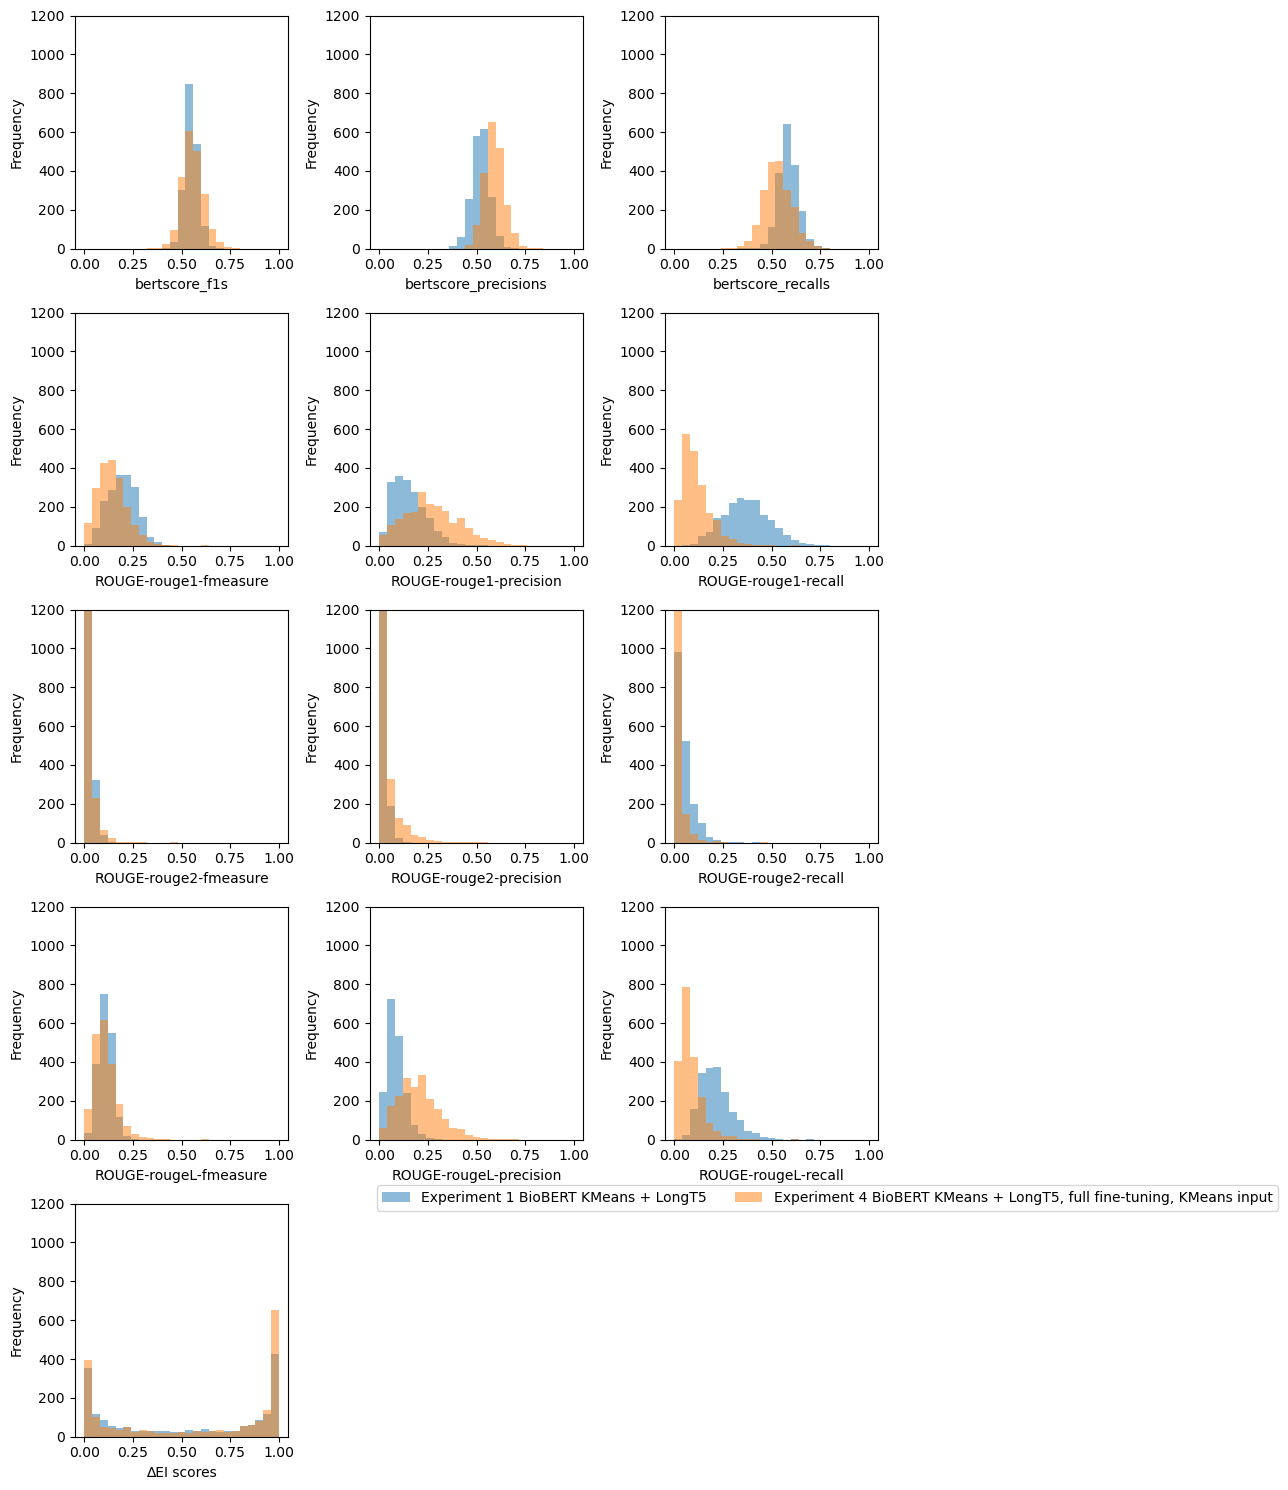

In [406]:
models_to_investigate = [
    # "Baseline abstractive bioBART",
    # "Baseline abstractive Longt5",
    # "Baseline abstractive Pegasus",
    # "Baseline extractive BioBERT KMeans",
    # "Baseline extractive SciBERT KMeans",
    # "Baseline extractive BERT KMeans",
    "Experiment 1 BioBERT KMeans + LongT5",
    # "Experiment 2 BioBERT HDBSCAN + LongT5",
    # "Experiment 3 Rules-based extraction + LongT5",
    # "Experiment 4 LongT5, full fine-tuning, epoch 8, full input",
    # "Experiment 4 LongT5, full fine-tuning, epoch 9, full input",
    # "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, full input",
    # "Experiment 4 LongT5, full fine-tuning, KMeans input",
    "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input",
    # "Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning",
]
metrics = [
    "bertscore_f1s",
    "bertscore_precisions",
    "bertscore_recalls",
    "ROUGE-rouge1-fmeasure",
    "ROUGE-rouge1-precision",
    "ROUGE-rouge1-recall",
    "ROUGE-rouge2-fmeasure",
    "ROUGE-rouge2-precision",
    "ROUGE-rouge2-recall",
    "ROUGE-rougeL-fmeasure",
    "ROUGE-rougeL-precision",
    "ROUGE-rougeL-recall",
    "∆EI scores",
]

num_rows = 5
max_freq = 1200
fig_length = 3
print_df = False
# --- END OF CONFIG ---
assert len(models_to_investigate) <= 2
dataset = load_dataset("allenai/mslr2022", "ms2", split="validation")
num_cols = (len(metrics) - 1) // num_rows + 1
fig = plt.figure(figsize=(num_cols * fig_length, num_rows * fig_length))
for m, metric in enumerate(metrics):
    ax = fig.add_subplot(num_rows, num_cols, m + 1)
    for model_to_investigate in models_to_investigate:
        summary_key = df_model_info[df_model_info["model_name"] == model_to_investigate]["column_for_generated_text"].iloc[0]

        # find the docid with the highest and lowest metric
        # rename for convenience:
        results[model_to_investigate]["∆EI scores"] = results[model_to_investigate]["evidence_inference_divergence"]["scores"]
        for rouge_type in ["rouge1", "rouge2", "rougeL"]:
            for metric_type in ["fmeasure", "precision", "recall"]:
                try:
                    results[model_to_investigate][f"ROUGE-{rouge_type}-{metric_type}"] = [getattr(s, metric_type) for s in results[model_to_investigate]["rouge"][rouge_type + "_individual"]]
                except KeyError:
                    pass

        metric_as_series = pd.Series(results[model_to_investigate][metric])
        metric_min_idx, metric_max_idx = metric_as_series.idxmin(), metric_as_series.idxmax()

        # find the entry
        csv_path = df_model_info[df_model_info["model_name"] == model_to_investigate]["generated_summaries_path"].iloc[0]
        df = pd.read_csv(csv_path)

        df_min_max = pd.DataFrame({
            "min": df.iloc[metric_min_idx][summary_key],
            "max": df.iloc[metric_max_idx][summary_key],
        }, index=["summary"]).T
        df_min_max["review_id"] = [df.iloc[metric_min_idx]["review_id"], df.iloc[metric_max_idx]["review_id"]]
        df_min_max["target"] = [dataset[dataset["review_id"].index(str(docid))]["target"] for docid in df_min_max["review_id"]]
        df_min_max["background"] = [dataset[dataset["review_id"].index(str(docid))]["background"] for docid in df_min_max["review_id"]]
        df_min_max["score"] = [metric_as_series[metric_min_idx], metric_as_series[metric_max_idx]]
        df_min_max = df_min_max[["review_id", "background", "target", "summary", "score"]]
        df_min_max.rename(columns={"score": metric, "summary": f"{model_to_investigate} summary"}, inplace=True)

        # display settings
        pd.options.display.max_colwidth = 3000
        pd.options.display.float_format = "{:.3f}".format

        if print_df:
            display(df_min_max)

        # plot distribution of metric
        num_bins = 25
        bins = np.arange(0, 1 + 1 / num_bins, 1 / num_bins)
        metric_as_series.hist(bins=bins, alpha=0.5, label=model_to_investigate, ax=ax)

    # ax.set_title(f"Distribution of {metric}")
    ax.set_xlabel(metric)
    ax.set_ylabel("Frequency")
    ax.set_ylim(0, max_freq)
    ax.grid(False)

# ax.legend()
plt.tight_layout()
ax = fig.axes[-num_cols]
ax.legend(bbox_to_anchor=(0, - 0.5 / fig_length), loc="upper left", ncol=2)



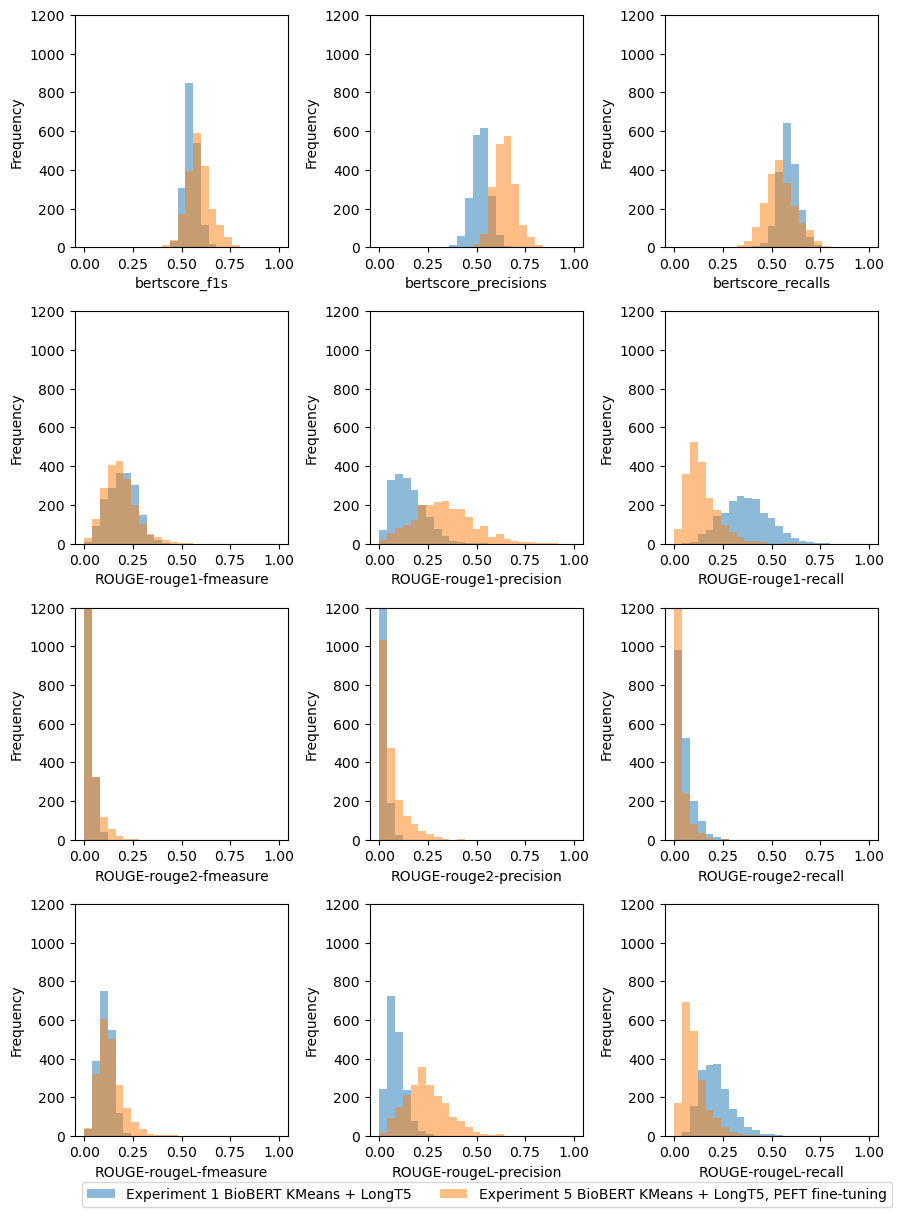

In [389]:
models_to_investigate = [
    "Experiment 1 BioBERT KMeans + LongT5",
    # "Experiment 2 BioBERT HDBSCAN + LongT5",
    "Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning",
]
metrics = [
    # # "∆EI scores",
    "bertscore_f1s",
    "bertscore_precisions",
    "bertscore_recalls",
    "ROUGE-rouge1-fmeasure",
    "ROUGE-rouge1-precision",
    "ROUGE-rouge1-recall",
    "ROUGE-rouge2-fmeasure",
    "ROUGE-rouge2-precision",
    "ROUGE-rouge2-recall",
    "ROUGE-rougeL-fmeasure",
    "ROUGE-rougeL-precision",
    "ROUGE-rougeL-recall",
]

num_rows = 4
max_freq = 1200
fig_length = 3
print_df = False
# --- END OF CONFIG ---
assert len(models_to_investigate) <= 2
dataset = load_dataset("allenai/mslr2022", "ms2", split="validation")
num_cols = (len(metrics) - 1) // num_rows + 1
fig = plt.figure(figsize=(num_cols * fig_length, num_rows * fig_length))
for m, metric in enumerate(metrics):
    ax = fig.add_subplot(num_rows, num_cols, m + 1)
    for model_to_investigate in models_to_investigate:
        summary_key = df_model_info[df_model_info["model_name"] == model_to_investigate]["column_for_generated_text"].iloc[0]

        # find the docid with the highest and lowest metric
        # rename for convenience:
        results[model_to_investigate]["∆EI scores"] = results[model_to_investigate]["evidence_inference_divergence"]["scores"]
        for rouge_type in ["rouge1", "rouge2", "rougeL"]:
            for metric_type in ["fmeasure", "precision", "recall"]:
                try:
                    results[model_to_investigate][f"ROUGE-{rouge_type}-{metric_type}"] = [getattr(s, metric_type) for s in results[model_to_investigate]["rouge"][rouge_type + "_individual"]]
                except KeyError:
                    pass

        metric_as_series = pd.Series(results[model_to_investigate][metric])
        metric_min_idx, metric_max_idx = metric_as_series.idxmin(), metric_as_series.idxmax()

        # find the entry
        csv_path = df_model_info[df_model_info["model_name"] == model_to_investigate]["generated_summaries_path"].iloc[0]
        df = pd.read_csv(csv_path)

        df_min_max = pd.DataFrame({
            "min": df.iloc[metric_min_idx][summary_key],
            "max": df.iloc[metric_max_idx][summary_key],
        }, index=["summary"]).T
        df_min_max["review_id"] = [df.iloc[metric_min_idx]["review_id"], df.iloc[metric_max_idx]["review_id"]]
        df_min_max["target"] = [dataset[dataset["review_id"].index(str(docid))]["target"] for docid in df_min_max["review_id"]]
        df_min_max["background"] = [dataset[dataset["review_id"].index(str(docid))]["background"] for docid in df_min_max["review_id"]]
        df_min_max["score"] = [metric_as_series[metric_min_idx], metric_as_series[metric_max_idx]]
        df_min_max = df_min_max[["review_id", "background", "target", "summary", "score"]]
        df_min_max.rename(columns={"score": metric, "summary": f"{model_to_investigate} summary"}, inplace=True)

        # display settings
        pd.options.display.max_colwidth = 3000
        pd.options.display.float_format = "{:.3f}".format

        if print_df:
            display(df_min_max)

        # plot distribution of metric
        num_bins = 25
        bins = np.arange(0, 1 + 1 / num_bins, 1 / num_bins)
        metric_as_series.hist(bins=bins, alpha=0.5, label=model_to_investigate, ax=ax)

    # ax.set_title(f"Distribution of {metric}")
    ax.set_xlabel(metric)
    ax.set_ylabel("Frequency")
    ax.set_ylim(0, max_freq)
    ax.grid(False)

# ax.legend()
plt.tight_layout()
ax = fig.axes[-num_cols]
ax.legend(bbox_to_anchor=(0, - 0.5 / fig_length), loc="upper left", ncol=2)



In [270]:
# df_min_max to clipboard
df_min_max.to_clipboard(index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


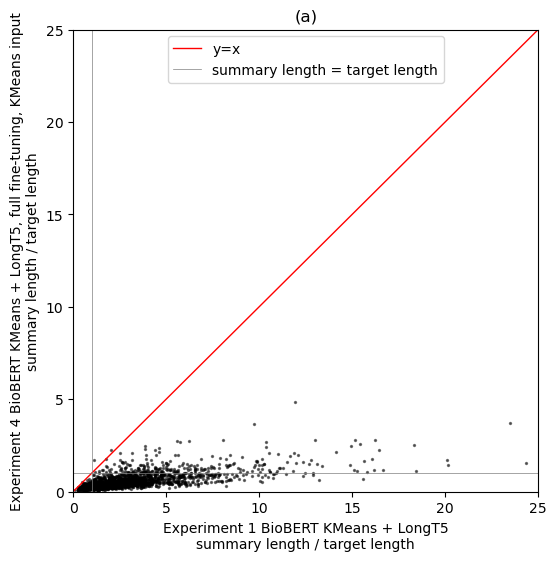

In [407]:
# plot difference in summaries length (char) in models
# for each paired example, set y-axis as summary lengths of first model, x-axis as summary lengths of second model
# plot a scatter plot

# first, pair up examples from the two models
model1, model2 = models_to_investigate
df_model1_info = df_model_info[df_model_info["model_name"] == model1]
df_model2_info = df_model_info[df_model_info["model_name"] == model2]

df_model1 = pd.read_csv(df_model1_info["generated_summaries_path"].iloc[0])
df_model2 = pd.read_csv(df_model2_info["generated_summaries_path"].iloc[0])

df_model1.rename(columns={df_model1_info["column_for_generated_text"].iloc[0]: "summary", df_model1_info["column_for_review_id"].iloc[0]: "review_id"}, inplace=True)
df_model2.rename(columns={df_model2_info["column_for_generated_text"].iloc[0]: "summary", df_model2_info["column_for_review_id"].iloc[0]: "review_id"}, inplace=True)
df_merged = df_model1.merge(df_model2, on="review_id", suffixes=("_model1", "_model2"))

# also add target
df_merged["target"] = [dataset[dataset["review_id"].index(str(docid))]["target"] for docid in df_merged["review_id"]]

# batch tokenize summaries and target -- get length only!
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("pszemraj/long-t5-tglobal-base-16384-book-summary")
df_merged["summary_model1_length"] = tokenizer.batch_encode_plus(df_merged["summary_model1"].tolist(), return_length=True)["length"]
df_merged["summary_model2_length"] = tokenizer.batch_encode_plus(df_merged["summary_model2"].tolist(), return_length=True)["length"]
df_merged["target_length"] = tokenizer.batch_encode_plus(df_merged["target"].tolist(), return_length=True)["length"]

# calculate ratio of summary length to target length
df_merged["len(model1 summary) / len(target)"] = df_merged["summary_model1_length"] / df_merged["target_length"]
df_merged["len(model2 summary) / len(target)"] = df_merged["summary_model2_length"] / df_merged["target_length"]

# finally plot
fig = plt.figure(figsize=(6, 6))
max_ratio = max(df_merged["len(model1 summary) / len(target)"].max(), df_merged["len(model2 summary) / len(target)"].max())
max_ratio = np.ceil(max_ratio / 5) * 5
# plot y=x line
plt.plot([0, max_ratio], [0, max_ratio], color="red", lw=1, label="y=x")
# also plot ratio=1 lines
plt.plot([1, 1], [0, max_ratio], color="grey", lw=0.5, linestyle="-", label="summary length = target length")
plt.plot([0, max_ratio], [1, 1], color="grey", lw=0.5, linestyle="-")

plt.scatter(df_merged["len(model1 summary) / len(target)"], df_merged["len(model2 summary) / len(target)"], alpha=0.5, s=2, color="black")

plt.xlabel(f"{model1}\nsummary length / target length")
plt.ylabel(f"{model2}\nsummary length / target length")
plt.xlim(0, max_ratio)
plt.ylim(0, max_ratio)

# ticks should be in increments of 5.0
plt.xticks(np.arange(0, max_ratio + 1, 5.0))
plt.yticks(np.arange(0, max_ratio + 1, 5.0))

plt.legend()

# plt.title(f"Summary length ratio comparison");
plt.title(f"(a)");
# plt.title(f"(b)");

In [474]:
# model_to_investigate = "Baseline extractive BioBERT KMeans"
model_to_investigate = "Experiment 1 BioBERT KMeans + LongT5"
# model_to_investigate = "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input"

id_to_investigate = 32174622

pprint(dataset[dataset["review_id"].index(str(id_to_investigate))]["background"])
pprint(dataset[dataset["review_id"].index(str(id_to_investigate))]["target"])

_df_model_to_investigate = pd.read_csv(df_model_info[df_model_info["model_name"] == model_to_investigate]["generated_summaries_path"].iloc[0])
summary_key = df_model_info[df_model_info["model_name"] == model_to_investigate]["column_for_generated_text"].iloc[0]
pprint(_df_model_to_investigate.iloc[_df_model_to_investigate["review_id"].tolist().index(id_to_investigate)][summary_key])

('Background : Stainless steel crowns ( SSCs ) are unique coronal restorative '
 'material s used commonly in the management of primary teeth with extensive '
 'caries .\n'
 'Aim : The aim of this study was to perform a systematic review to evaluate '
 'the retentive strength of luting cements for SSCs .')
('Conclusion : Within the limitations of this study , thein vitro literature '
 'seems to suggest that the use of self-adhesive resin cements shows higher '
 'retentive strength , followed by resin-modified glass-ionomer cement ( '
 'RM-GIC ) and conventional GIC .\n'
 'However , RM-GIC can be a preferred luting agent due to its clinical '
 'advantages over resin cements .\n'
 'Thus , it can be concluded that choice of cement will depend on individual '
 'patient needs and clinical situation')
('The survival rate of different material crowns is compared in this paper. '
 'For example, the survival time of a single-rooted tooth is calculated after '
 'examining 1,065 patients with pri

In [ ]:
model_to_investigate = "Baseline extractive BioBERT KMeans"
_df_model_to_investigate = pd.read_csv(df_model_info[df_model_info["model_name"] == model_to_investigate]["generated_summaries_path"].iloc[0])
_df_model_to_investigate.iloc[_df_model_to_investigate["review_id"].tolist().index(26210195)]

In [445]:
dataset[dataset["review_id"].index(str("32174622"))]["target"]

_df_model1[_df_model1["review_id"].astype(str).isin(["32174622"])]  #[df_model_info[df_model_info["model_name"] == model1]["column_for_generated_text"].iloc[0]].tolist()
# _df_model2[_df_model2["review_id"].astype(str).isin(["31583381"])]  #[df_model_info[df_model_info["model_name"] == model1]["column_for_generated_text"].iloc[0]].tolist()

,review_id,Summary
1100,32174622,"The survival rate of different material crowns is compared in this paper. For example, the survival time of a single-rooted tooth is calculated after examining 1,065 patients with primary morals. A highly significant difference is found among the success rates of various material restorations; for example: preformed crownS, amalgam, composite resin S, and glass Ionomer C. In addition, there are no differences in the lifetime or replacement rate when comparing cements used as dowels on cast teeth."


In [440]:
print(overlapping_review_ids[777])
print(len(overlapping_review_ids))

32174622
1861


In [ ]:
print(summaries_model1[777])
print(len(summaries_model1))

The effect of a high-dose vitamin D regimen on insulin resistance among women with polycytic oovary syndrome is investigated. In this study, the effects of daily ricota cheese on muscle mass, strength, and physical function are examined in elderly subjects. Although there is no significant change in body composition or muscle size between groups, it is suggested that adding 210g of cottage cheese daily may improve these results.
1861


In [ ]:
print(summaries_model2[777])
print(len(summaries_model2))

['The findings of this review suggest that older men have a similar peak torque to younger women.']
1861


In [441]:
print(target_texts[777])
print(len(target_texts))

Conclusion : Within the limitations of this study , thein vitro literature seems to suggest that the use of self-adhesive resin cements shows higher retentive strength , followed by resin-modified glass-ionomer cement ( RM-GIC ) and conventional GIC .
However , RM-GIC can be a preferred luting agent due to its clinical advantages over resin cements .
Thus , it can be concluded that choice of cement will depend on individual patient needs and clinical situation
1861


In [444]:
dataset[dataset["review_id"].index("32174622")]

{'review_id': '32174622',
 'pmid': ['7937261',
  '8941814',
  '15870802',
  '20831131',
  '10762680',
  '11813717',
  '15382776',
  '16336233'],
 'title': ['The influence of restorative material on the survival rate of restorations in primary molars.',
  'Stainless steel crown versus multisurface amalgam restorations: an 8-year longitudinal clinical study.',
  'The survival of resin modified glass ionomer and stainless steel crown restorations in primary molars, placed in a specialist paediatric dental practice',
  'Retentive strength of luting cements for stainless steel crowns: an in vitro study.',
  'The influence of luting cement on the probabilities of survival and modes of failure of cast full-coverage crowns.',
  'A comparative study of retentive strengths of zinc phosphate, polycarboxylate and glass ionomer cements with stainless steel crowns--an in vitro study.',
  'Conservative dental surgery: A split-mouth randomized clinical trial of single crowns retained with resin-modifi

Mean difference: 0.041


,target,abstract_title,Experiment 1 BioBERT KMeans + LongT5 summary,Experiment 1 BioBERT KMeans + LongT5 bertscore_f1s,"Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning summary","Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning bertscore_f1s","Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning - Experiment 1 BioBERT KMeans + LongT5"
review_id,,,,,,,
32149404,Perioperative risk factors were inconsistently associated with developmental outcomes .\nINTERPRETATION The literature on children undergoing surgery in early infancy suggests that infants with a single ventricle are at highest risk of adverse developmental outcomes .\nWHAT THIS PAPER ADDS Children with complex congenital heart disease ( CHD ) are at increased risk of impaired developmental outcome .\nChildren with single-ventricle CHD have worse outcomes than children with two-ventricle CHD .\nChildren with two-ventricle CHD gradually grow out of their initial developmental impairment .\nPerioperative factors are inconsistently associated with outcome,"[Chronic Neuromotor Disability After Complex Cardiac Surgery in Early Life, Developmental and neurological status of children at 4 years of age after heart surgery with hypothermic circulatory arrest or low-flow cardiopulmonary bypass., Intraoperative Hyperglycemia during Infant Cardiac Surgery Is Not Associated with Adverse Neurodevelopmental Outcomes at 1, 4, and 8 Years, Prediction of IQ and Achievement at Age 8 Years From Neurodevelopmental Status at Age 1 Year in Children With D-Transposition of the Great Arteries, Developmental and neurologic status of children after heart surgery with hypothermic circulatory arrest or low-flow cardiopulmonary bypass., Clinical and Functional Developmental Outcomes in Neonates Undergoing Truncus Arteriosus Repair: A Cohort Study., Structural cerebral abnormalities and neurodevelopmental status in single ventricle congenital heart disease before Fontan procedure, Prevalence of Childhood Permanent Hearing Loss after Early Complex Cardiac Surgery, Prospective follow-up study of children with univentricular heart: neurodevelopmental outcome at age 12 months., Fetal cerebrovascular resistance and neonatal EEG predict 18-month neurodevelopmental outcome in infants with congenital heart disease., Early childhood language outcomes after arterial switch operation: a prospective cohort study, How much loss to follow-up is acceptable in long-term randomised trials and prospective studies?, Effect of prenatal diagnosis on outcomes in D-transposition of the great arteries., Neurodevelopmental Burden at Age 5 Years in Patients With Univentricular Heart, Sepsis After Cardiac Surgery Early in Infancy and Adverse 4.5-Year Neurocognitive Outcomes, Relation of seizures after cardiac surgery in early infancy to neurodevelopmental outcome. Boston Circulatory Arrest Study Group., Patterns of Developmental Dysfunction After Surgery During Infancy to Correct Transposition of the Great Arteries, Two-Year Survival and Mental and Psychomotor Outcomes After the Norwood Procedure: An Analysis of the Modified Blalock-Taussig Shunt and Right Ventricle–to–Pulmonary Artery Shunt Surgical Eras, Neurodevelopmental Outcomes in Children Surviving d‐Transposition of the Great Arteries, Mortality and neurodevelopmental outcome at 1 year of age comparing hybrid and Norwood procedures., Adolescents With d-Transposition of the Great Arteries Corrected With the Arterial Switch Procedure: Neuropsychological Assessment and Structural Brain Imaging, Changing expectations for neurological outcomes after the neonatal arterial switch operation., Prediction of preschool functional abilities after early complex cardiac surgery., Neurodevelopmental status at eight years in children with dextro-transposition of the great arteries: the Boston Circulatory Arrest Trial., Risk factors for preoperative periventricular leukomalacia in term neonates with hypoplastic left heart syndrome are patient related., Association of hemog

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


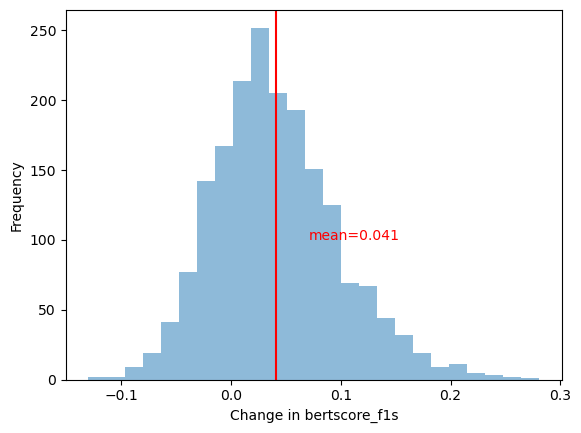

In [557]:
# Specify the names of model1 and model2
model1 = "Experiment 1 BioBERT KMeans + LongT5"
# model2 = "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input"
model2 = "Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning"

# Specify the selected metric
selected_metric = "bertscore_f1s"
# selected_metric = "∆EI scores"
# selected_metric = "ROUGE-rouge1-fmeasure"

# get the overlapping review_ids for both results
overlapping_review_ids = list(set(results[model1]["review_ids"]).intersection(set(results[model2]["review_ids"])))

# also get the actual summaries.
_df_model1 = pd.read_csv(df_model_info[df_model_info["model_name"] == model1]["generated_summaries_path"].iloc[0])
_df_model2 = pd.read_csv(df_model_info[df_model_info["model_name"] == model2]["generated_summaries_path"].iloc[0])
summaries_model1 = [_df_model1.iloc[_df_model1["review_id"].astype(str).tolist().index(docid)][df_model_info[df_model_info["model_name"] == model1]["column_for_generated_text"].iloc[0]] for docid in overlapping_review_ids]
summaries_model2 = [_df_model2.iloc[_df_model2["review_id"].astype(str).tolist().index(docid)][df_model_info[df_model_info["model_name"] == model2]["column_for_generated_text"].iloc[0]] for docid in overlapping_review_ids]
target_texts = [dataset[dataset["review_id"].index(str(docid))]["target"] for docid in overlapping_review_ids]
abstract_titles = [dataset[dataset["review_id"].index(str(docid))]["title"] for docid in overlapping_review_ids]

# Get the metric values for model1 and model2, but only for the overlapping review_ids (in the order of overlapping_review_ids)
metric_values_model1 = np.array([float(results[model1][selected_metric][_df_model1["review_id"].astype(str).tolist().index(docid)]) for docid in overlapping_review_ids])
metric_values_model2 = np.array([float(results[model2][selected_metric][_df_model2["review_id"].astype(str).tolist().index(docid)]) for docid in overlapping_review_ids])

# Calculate the per-example difference
per_example_difference = pd.Series(metric_values_model2 - metric_values_model1)

# put into a dataframe
df_per_example_difference = pd.DataFrame({
    "review_id": overlapping_review_ids,
    "target": target_texts,
    "abstract_title": abstract_titles,
    f"{model1} summary": summaries_model1,
    f"{model1} {selected_metric}": metric_values_model1,
    f"{model2} summary": summaries_model2,
    f"{model2} {selected_metric}": metric_values_model2,
    f"{model2} - {model1}": per_example_difference,
}).set_index("review_id")

# plot histogram of per-example difference
per_example_difference.hist(bins=25, alpha=0.5, label=f"{model2} - {model1}")

# what's the mean?
mean_difference = per_example_difference.mean()
plt.axvline(mean_difference, color="red", label=f"mean={mean_difference:.3f}")
plt.text(mean_difference + 0.03, 100, f"mean={mean_difference:.3f}", color="red")
print(f"Mean difference: {mean_difference:.3f}")

plt.grid(False)

plt.xlabel(f"Change in {selected_metric}")
plt.ylabel("Frequency")

# in df_per_example_difference, get min max of per-example difference, display
min_difference_idx = per_example_difference.idxmin()
max_difference_idx = per_example_difference.idxmax()
display(df_per_example_difference_min_max := df_per_example_difference.iloc[[min_difference_idx, max_difference_idx]])
df_per_example_difference_min_max.to_clipboard()

In [672]:
results[models_to_investigate[0][0]].keys()

dict_keys(['review_ids', 'rouge', 'bertscore_precisions', 'bertscore_recalls', 'bertscore_f1s', 'bertscore_avg_precision', 'bertscore_avg_recall', 'bertscore_avg_f1', 'bertscore_std_precision', 'bertscore_std_recall', 'bertscore_std_f1', 'evidence_inference_divergence', 'deltaEI'])

(0, 0), 
(1, 0), (1, 1), 
(2, 0), (2, 1), (2, 2), 
(3, 0), (3, 1), (3, 2), (3, 3), 
(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), 
(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), 
(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), 
(7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), 


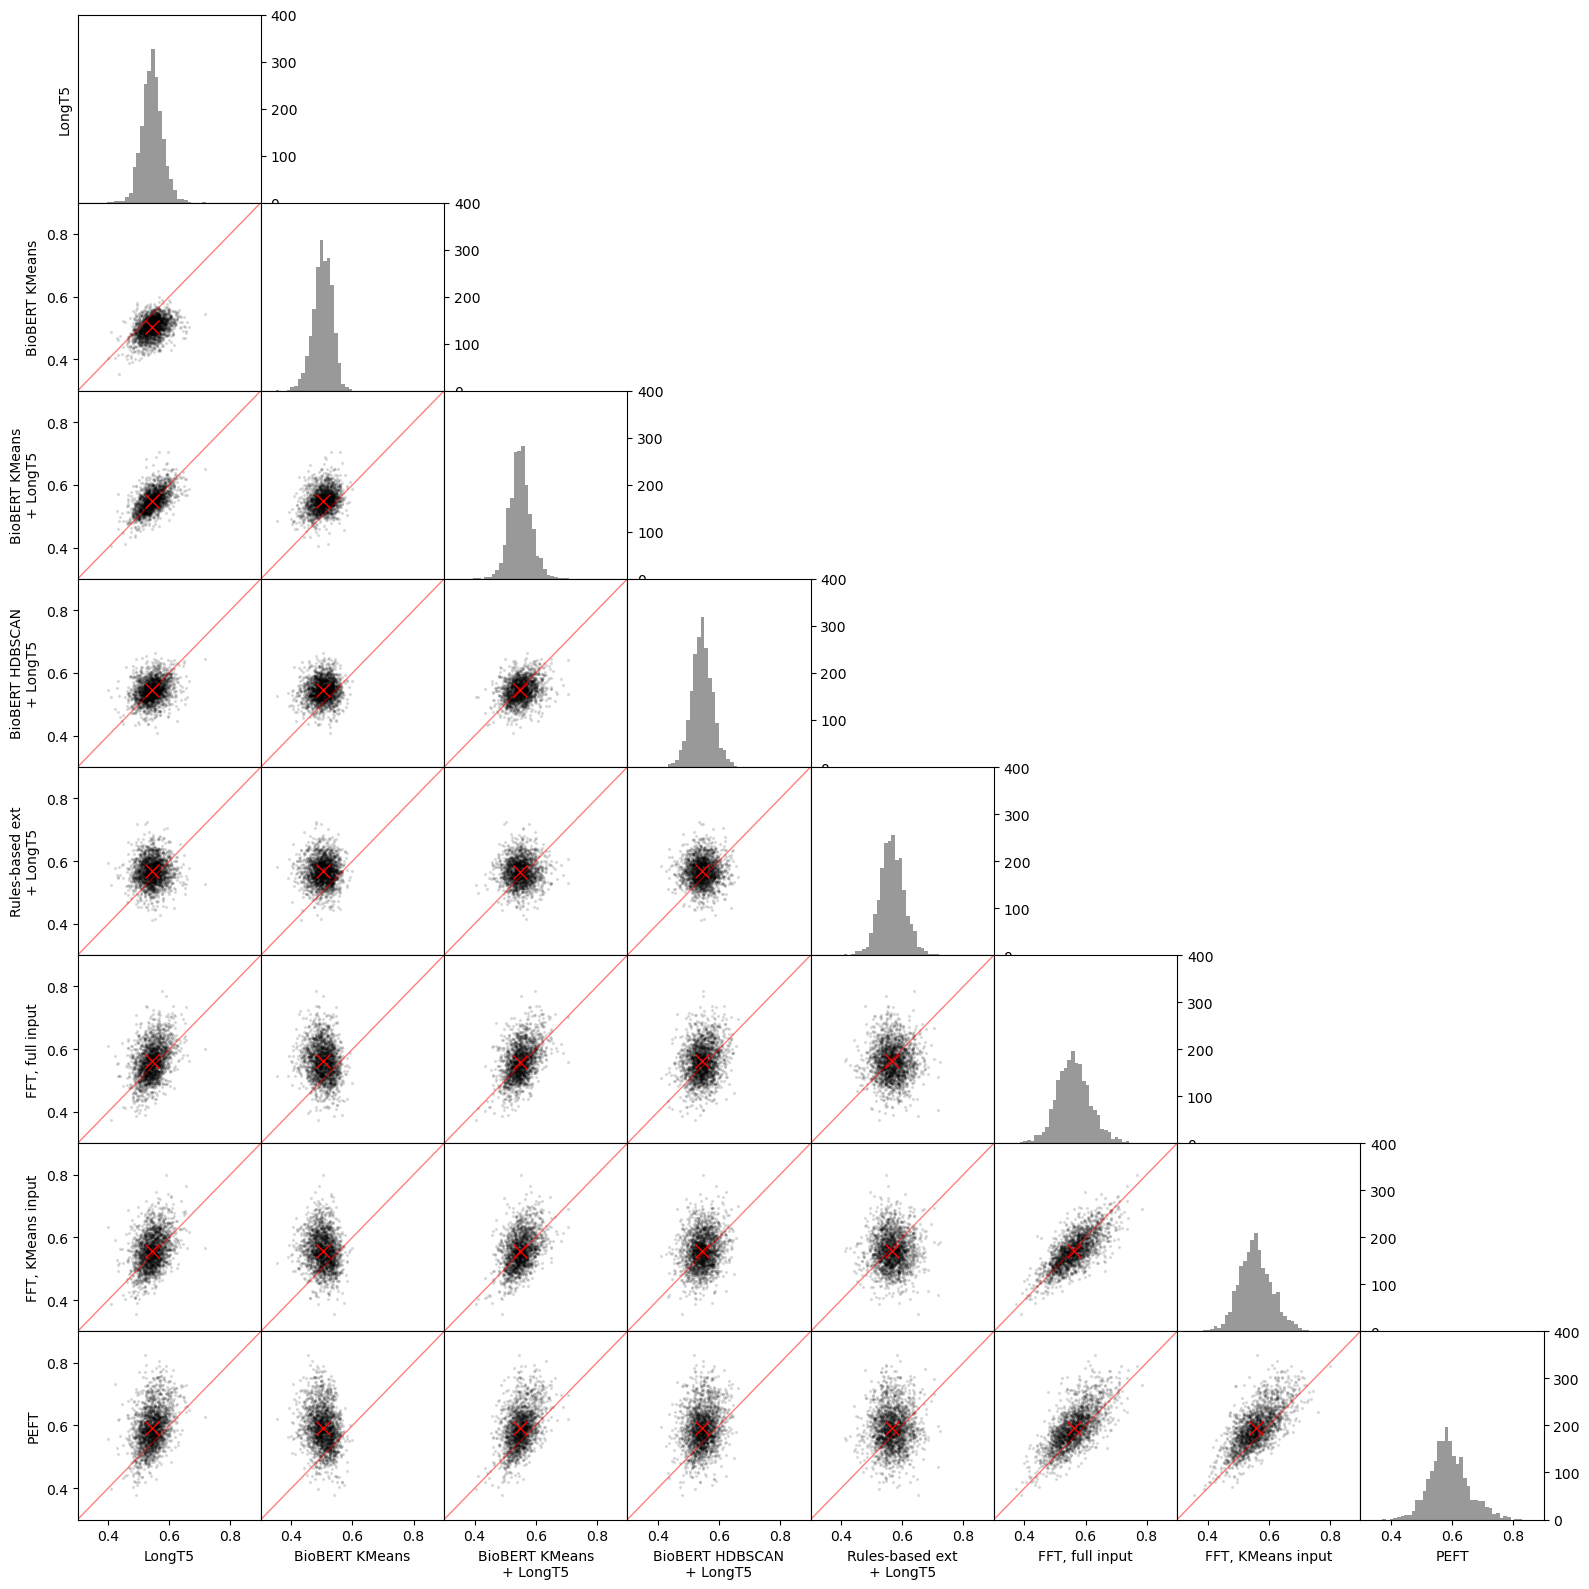

In [706]:
# Plot models against each other

models_to_investigate = [
    ('Baseline abstractive Longt5', "LongT5"),
    ('Baseline extractive BioBERT KMeans', "BioBERT KMeans"),
    ('Experiment 1 BioBERT KMeans + LongT5', "BioBERT KMeans\n+ LongT5"),
    ('Experiment 2 BioBERT HDBSCAN + LongT5', "BioBERT HDBSCAN\n+ LongT5"),
    ('Experiment 3 Rules-based extraction + LongT5', "Rules-based ext\n+ LongT5"),
    ('Experiment 4 LongT5, full fine-tuning, epoch 9, full input', "FFT, full input"),
    ('Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input', "FFT, KMeans input"),
    ('Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning', "PEFT"),
]

# Specify the selected metric
selected_metrics = [
    "bertscore_f1s",
    # "deltaEI",
    # "ROUGE-rouge1-fmeasure",
    # "ROUGE-rouge2-fmeasure",
    # "ROUGE-rougeL-fmeasure",
]
for selected_metric in selected_metrics:

    if selected_metric == "deltaEI":
        # convenience conversion:
        for model in models_to_investigate:
            results[model[0]]["deltaEI"] = results[model[0]]["evidence_inference_divergence"]["scores"]

    elif selected_metric.startswith("ROUGE"):
        for model in models_to_investigate:
            rouge_type = selected_metric.split("-")[1]
            metric_type = selected_metric.split("-")[2]
            try:
                results[model[0]][f"ROUGE-{rouge_type}-{metric_type}"] = [getattr(s, metric_type) for s in results[model[0]]["rouge"][rouge_type + "_individual"]]
            except KeyError:
                pass

    # Make something like a facetgrid but in matplotlib, with rows and columns being the models.
    # Histograms of the selected metric along the diagonal. Scatter plots of the selected metric between models in the off-diagonals.
    # Off diagonals: also plot y=x line.
    # Off diagonals: only plot for bottom triangle (i.e. model1 vs model2, not model2 vs model1)

    # what's the min and max of the selected metric?
    min_metric = float(min([min(results[model][selected_metric]) for (model, _) in models_to_investigate]))
    max_metric = float(max([max(results[model][selected_metric]) for (model, _) in models_to_investigate]))
    interval = 0.25
    min_metric = np.floor(min_metric * (1 / interval)) / (1 / interval)
    max_metric = np.ceil(max_metric * (1 / interval)) / (1 / interval)
    ticks = np.arange(min_metric, max_metric + interval, interval)

    # manual
    ticks = [0.4, 0.6, 0.8]
    min_metric = 0.3
    max_metric = 0.9

    # histogram settings
    num_bins = 50
    bins = np.arange(min_metric, max_metric + (max_metric - min_metric) / num_bins, (max_metric - min_metric) / num_bins)
    max_freq = 400
    hist_ticks = [0, 100, 200, 300, 400]

    num_rows = len(models_to_investigate)
    num_cols = len(models_to_investigate)
    sublpot_size = 2
    fig = plt.figure(figsize=(num_cols * sublpot_size, num_rows * sublpot_size))
    for r, (model1, model1_name) in enumerate(models_to_investigate):
        for c, (model2, model2_name) in enumerate(models_to_investigate):
            ax = fig.add_subplot(num_rows, num_cols, r * num_cols + c + 1)

            _df_model1 = pd.read_csv(df_model_info[df_model_info["model_name"] == model1]["generated_summaries_path"].iloc[0])
            _df_model2 = pd.read_csv(df_model_info[df_model_info["model_name"] == model2]["generated_summaries_path"].iloc[0])
            model1_review_id_col = df_model_info[df_model_info["model_name"] == model1]["column_for_review_id"].iloc[0]
            model2_review_id_col = df_model_info[df_model_info["model_name"] == model2]["column_for_review_id"].iloc[0]
            # if same model, plot histogram
            if model1 == model2:
                metric_values_model1 = np.array([float(results[model1][selected_metric][_df_model1[model1_review_id_col].astype(str).tolist().index(docid)]) for docid in results[model1]["review_ids"]])
                metric_values_model1 = pd.Series(metric_values_model1)
                metric_values_model1.hist(bins=bins, alpha=0.8, label=model1, ax=ax, color="grey")
                ax.set_xlim(min_metric, max_metric)
                ax.set_ylim(0, max_freq)
                ax.set_xticks(ticks)
                ax.set_yticks(hist_ticks)
                ax.yaxis.tick_right()
                ax.grid(False)

            elif c > r:
                # skip!
                ax.axis("off")
                continue

            else:
                # otherwise, plot scatter plot
                # get the overlapping review_ids for both results
                overlapping_review_ids = list(set(results[model1]["review_ids"]).intersection(set(results[model2]["review_ids"])))

                # also get the actual summaries.
                summaries_model1 = [_df_model1.iloc[_df_model1[model1_review_id_col].astype(str).tolist().index(docid)][df_model_info[df_model_info["model_name"] == model1]["column_for_generated_text"].iloc[0]] for docid in overlapping_review_ids]
                summaries_model2 = [_df_model2.iloc[_df_model2[model2_review_id_col].astype(str).tolist().index(docid)][df_model_info[df_model_info["model_name"] == model2]["column_for_generated_text"].iloc[0]] for docid in overlapping_review_ids]
                target_texts = [dataset[dataset["review_id"].index(str(docid))]["target"] for docid in overlapping_review_ids]
                abstract_titles = [dataset[dataset["review_id"].index(str(docid))]["title"] for docid in overlapping_review_ids]

                # Get the metric values for model1 and model2, but only for the overlapping review_ids (in the order of overlapping_review_ids)
                metric_values_model1 = np.array([float(results[model1][selected_metric][_df_model1[model1_review_id_col].astype(str).tolist().index(docid)]) for docid in overlapping_review_ids])
                metric_values_model2 = np.array([float(results[model2][selected_metric][_df_model2[model2_review_id_col].astype(str).tolist().index(docid)]) for docid in overlapping_review_ids])

                # Calculate the per-example difference
                per_example_difference = pd.Series(metric_values_model2 - metric_values_model1)

                # put into a dataframe
                df_per_example_difference = pd.DataFrame({
                    "review_id": overlapping_review_ids,
                    "target": target_texts,
                    "abstract_title": abstract_titles,
                    f"{model1} summary": summaries_model1,
                    f"{model1} {selected_metric}": metric_values_model1,
                    f"{model2} summary": summaries_model2,
                    f"{model2} {selected_metric}": metric_values_model2,
                    f"{model2} - {model1}": per_example_difference,
                }).set_index("review_id")

                # mean value of metric values
                mean_metric_model1 = metric_values_model1.mean()
                mean_metric_model2 = metric_values_model2.mean()

                # plot scatter plot
                ax.scatter(metric_values_model2, metric_values_model1, alpha=0.1, s=2, color="black")

                # plot mean value of metric values
                ax.plot([mean_metric_model2], [mean_metric_model1], marker="x", color="red", markersize=10)

                # plot y=x line
                ax.plot([0, max_metric], [0, max_metric], color="red", lw=1, label="y=x", alpha=0.5)

                ax.set_xlim(min_metric, max_metric)
                ax.set_ylim(min_metric, max_metric)
                ax.set_xticks(ticks)
                ax.set_yticks(ticks)

                if c != 0:
                    ax.tick_params(axis="y", colors=(1, 1, 1, 0))

            plt.grid(False)
            if r == num_rows - 1:  # bottom row
                ax.set_xlabel(model2_name)
            else:
                ax.tick_params(axis="x", colors=(1, 1, 1, 0))
            if c == 0:
                ax.set_ylabel(model1_name)

            print(f"({r}, {c}), ", end="")

        print()

    # tight and wspace
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

    # savefig
    fig.savefig(f"evaluator/figures/scatterplot_{selected_metric.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")

In [657]:
fig.savefig(f"evaluator/figures/scatterplot_{selected_metric.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")

/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_57728/408149400.py:29: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


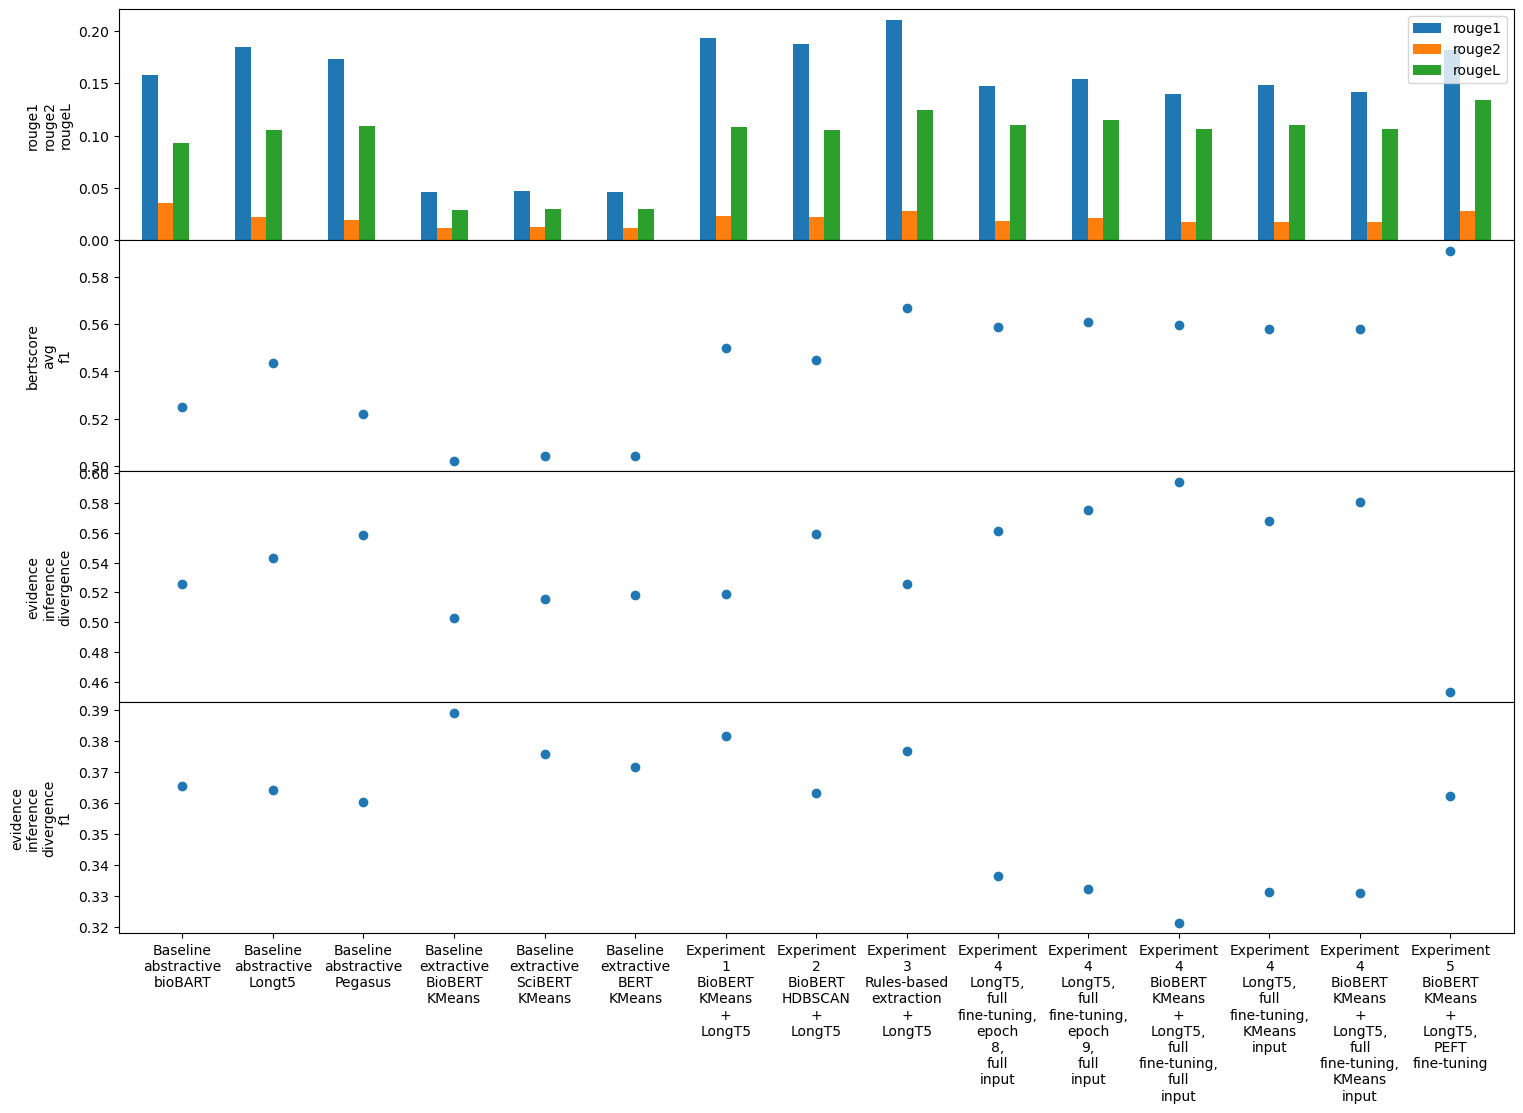

In [558]:
fig = plt.figure(figsize=(18, 12))
for mg_idx, metric_group in enumerate([
    ["rouge1", "rouge2", "rougeL"],
    ["bertscore_avg_f1"],
    ["evidence_inference_divergence"],
    ["evidence_inference_divergence_f1"],
]):
    ax = fig.add_subplot(4, 1, mg_idx + 1)
    if mg_idx == 0:
        df_results[metric_group].plot.bar(rot=90, title=metric_group[0], ax=ax)
    else:
        # use scatter plot instead of bar plot. set x to be enumerate(df_results.index)
        ax.scatter(x=range(len(df_results)), y=df_results[metric_group[0]], label=metric_group[0])

    plt.ylabel("\n".join(metric_group).replace("_", "\n"))
    plt.title("")

    if mg_idx != 3:
        plt.xlabel("")
        # also set xticklabels to white
        ax.tick_params(axis='x', colors='white')
    else:
        # one tick per model (0 to len(df_results))
        ax.set_xticks(range(len(df_results)))

        # replace x tick labels "_" with "\n". make sure tick labels are set to the correct value
        ax.set_xticklabels(df_results.index.str.replace(" ", "\n").str.replace("-train", "\ntrain").tolist())

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

## Adhoc analysis

10084 out of 14188 examples are affected by the 2048 limit (71.07%)
1508 out of 14188 examples are affected by the 8192 limit (10.63%)


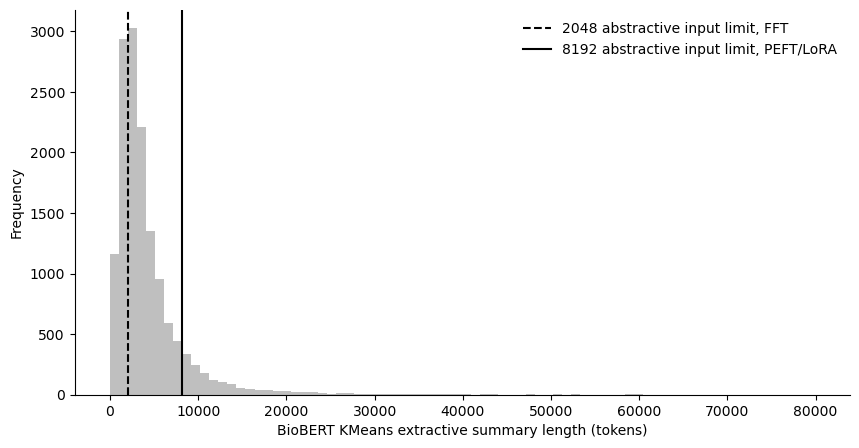

In [403]:
# MOTIVATION: how many examples are affected by the 2048 and 8192 limit?

from transformers import AutoTokenizer

# # open "Baseline extractive BioBERT KMeans" dataset, calculate token length of each summary
# # df_biobert_kmeans = pd.read_csv(df_model_info[df_model_info["model_name"] == "Baseline extractive BioBERT KMeans"]["generated_summaries_path"].iloc[0])  # validation data
# df_biobert_kmeans = pd.read_csv("experiment_1/biobert_extractive_only_training_dataset.csv.gz", compression="gzip")  # training data

# # batch tokenize summaries and target -- get length only!
# tokenizer = AutoTokenizer.from_pretrained("pszemraj/long-t5-tglobal-base-16384-book-summary")
# df_biobert_kmeans["summary_length"] = tokenizer.batch_encode_plus(df_biobert_kmeans["summary"].tolist(), return_length=True)["length"]

# plot histogram of summary length
max_length = df_biobert_kmeans["summary_length"].max()
bins = np.arange(0, max_length + 1024, 1024)  # bins of increments of 1024
fig = plt.figure(figsize=(10, 5))
df_biobert_kmeans["summary_length"].hist(bins=bins, alpha=0.5, color="grey")
# add line for 2048
plt.axvline(2048, color="black", linestyle="--", label="2048 abstractive input limit, FFT")
plt.axvline(8192, color="black", linestyle="-", label="8192 abstractive input limit, PEFT/LoRA")
plt.legend()
plt.xlabel("BioBERT KMeans extractive summary length (tokens)")
plt.ylabel("Frequency")
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().get_legend().get_frame().set_linewidth(0.0)

# what percentage of examples are affected by the 2048 limit?
print(f"{len(df_biobert_kmeans[df_biobert_kmeans['summary_length'] > 2048])} out of {len(df_biobert_kmeans)} examples are affected by the 2048 limit ({len(df_biobert_kmeans[df_biobert_kmeans['summary_length'] > 2048]) / len(df_biobert_kmeans) * 100:.2f}%)")
print(f"{len(df_biobert_kmeans[df_biobert_kmeans['summary_length'] > 8192])} out of {len(df_biobert_kmeans)} examples are affected by the 8192 limit ({len(df_biobert_kmeans[df_biobert_kmeans['summary_length'] > 8192]) / len(df_biobert_kmeans) * 100:.2f}%)")

In [481]:
df_results.index

Index(['Baseline abstractive bioBART', 'Baseline abstractive Longt5',
       'Baseline abstractive Pegasus', 'Baseline extractive BioBERT KMeans',
       'Baseline extractive SciBERT KMeans', 'Baseline extractive BERT KMeans',
       'Experiment 1 BioBERT KMeans + LongT5',
       'Experiment 2 BioBERT HDBSCAN + LongT5',
       'Experiment 3 Rules-based extraction + LongT5',
       'Experiment 4 LongT5, full fine-tuning, epoch 8, full input',
       'Experiment 4 LongT5, full fine-tuning, epoch 9, full input',
       'Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, full input',
       'Experiment 4 LongT5, full fine-tuning, KMeans input',
       'Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input',
       'Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning'],
      dtype='object', name='model')

In [522]:
# 4 models:
# 'Experiment 4 LongT5, full fine-tuning, epoch 9, full input'
# 'Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, full input'
# 'Experiment 4 LongT5, full fine-tuning, KMeans input'
# 'Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input'

# Examine the effects along two axes:
# 1. usage of KMeans input vs full input during training
# 2. usage of KMeans input vs full input during inference

organized_results = {}
for metric_to_investigate in df_results.columns:
    df_fft_metric = df_results.loc[
        [
            'Experiment 4 LongT5, full fine-tuning, epoch 9, full input',
            'Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, full input',
            'Experiment 4 LongT5, full fine-tuning, KMeans input',
            'Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input',
        ],
        [metric_to_investigate]
    ]
    # add to df_fft_metric two columns: "training input", "inference input". values: "full" and "kmeans"
    df_fft_metric["Training input"] = ["Full train", "KMeans train", "Full train", "KMeans train"]
    df_fft_metric["Inference input"] = ["Full infer", "Full infer", "KMeans infer", "KMeans infer"]

    # reshape: column: "Training input", index: "Inference input", value: metric score
    df_fft_metric = (
        df_fft_metric.reset_index(drop=True).rename(columns={metric_to_investigate: "score"})
        .pivot(index="Training input", columns="Inference input", values="score")
    )

    print(f"Metric: {metric_to_investigate}")
    print(df_fft_metric)
    print("\n")

    organized_results[metric_to_investigate] = df_fft_metric

# reorganize organized_results into a dataframe. multiindex column containing metric name and "Trainng input". index is "Inference input"
df_organized_results = pd.concat(organized_results, axis=1)
df_organized_results.columns = pd.MultiIndex.from_tuples(df_organized_results.columns)
# 3 decimals, as str. remove "0" and just show ".123"
df_organized_results = df_organized_results.applymap(lambda x: f"{x:.3f}".replace("0.", "."))
df_organized_results.to_clipboard()
df_organized_results

Metric: rouge1
Inference input  Full infer  KMeans infer
Training input                           
Full train            0.154         0.148
KMeans train          0.139         0.142


Metric: rouge2
Inference input  Full infer  KMeans infer
Training input                           
Full train            0.022         0.018
KMeans train          0.018         0.017


Metric: rougeL
Inference input  Full infer  KMeans infer
Training input                           
Full train            0.115         0.110
KMeans train          0.106         0.107


Metric: bertscore_avg_f1
Inference input  Full infer  KMeans infer
Training input                           
Full train            0.561         0.558
KMeans train          0.560         0.558


Metric: evidence_inference_divergence
Inference input  Full infer  KMeans infer
Training input                           
Full train            0.576         0.568
KMeans train          0.594         0.580


Metric: evidence_inference_divergence_f1
I

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


rouge1                  rouge2                  rougeL  \
               Full infer KMeans infer Full infer KMeans infer Full infer   
Training input                                                              
Full train           .154         .148       .022         .018       .115   
KMeans train         .139         .142       .018         .017       .106   

                            bertscore_avg_f1               \
               KMeans infer       Full infer KMeans infer   
Training input                                              
Full train             .110             .561         .558   
KMeans train           .107             .560         .558   

               evidence_inference_divergence               \
                                  Full infer KMeans infer   
Training input                                              
Full train                              .576         .568   
KMeans train                            .594         .580   

               evidence_inference_divergence_f1               
                                     Full infer KMeans infer  
Training input                                                
Full train                                 .332         .331  
KMeans train                               .321         .331

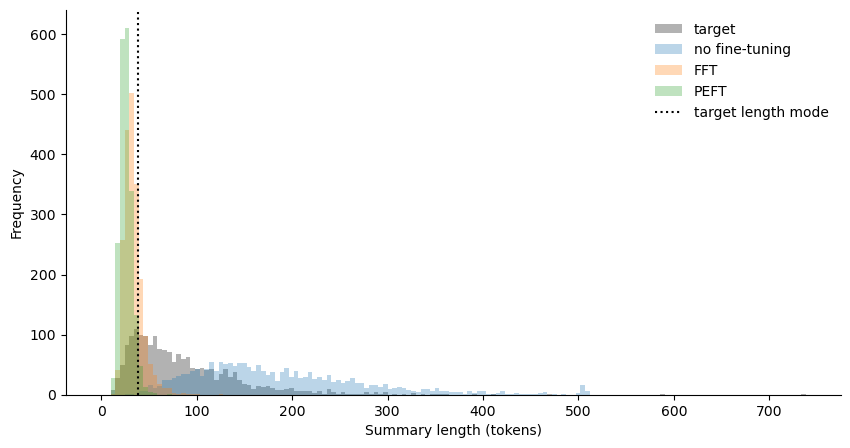

In [602]:
# View dataset targets -- plot length histogram

fig = plt.figure(figsize=(10, 5))

target_plotted = False

for mdl, label in [
    # ("Baseline abstractive Longt5", "Abstractive only, no fine-tuning"),
    ("Experiment 1 BioBERT KMeans + LongT5", "no fine-tuning"),
    ("Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input", "FFT"),
    # ("Experiment 4 LongT5, full fine-tuning, epoch 9, full input", "Extractive-Abstractive, FFT full both"),
    ("Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning", "PEFT"),
]:
    df_csv = pd.read_csv(df_model_info[df_model_info["model_name"] == mdl]["generated_summaries_path"].iloc[0])

    df_target_and_summary_lengths = pd.DataFrame(
        {
            "review_ids": df_csv[df_model_info[df_model_info["model_name"] == mdl]["column_for_review_id"].iloc[0]],
            "summary": df_csv[df_model_info[df_model_info["model_name"] == mdl]["column_for_generated_text"].iloc[0]],
            "target": [dataset[dataset["review_id"].index(str(docid))]["target"] for docid in df_csv[df_model_info[df_model_info["model_name"] == mdl]["column_for_review_id"].iloc[0]]],
        }
    )

    # batch tokenize summaries and target -- get length only!
    tokenizer = AutoTokenizer.from_pretrained("pszemraj/long-t5-tglobal-base-16384-book-summary")
    df_target_and_summary_lengths["summary_length"] = tokenizer.batch_encode_plus(df_target_and_summary_lengths["summary"].tolist(), return_length=True)["length"]
    if not target_plotted:
        df_target_and_summary_lengths["target_length"] = tokenizer.batch_encode_plus(df_target_and_summary_lengths["target"].tolist(), return_length=True)["length"]
        mean_target_length = df_target_and_summary_lengths["target_length"].mean()
        median_target_length = df_target_and_summary_lengths["target_length"].median()
        mode_target_length = df_target_and_summary_lengths["target_length"].mode()[0]
        max_length = max(df_target_and_summary_lengths["summary_length"].max(), df_target_and_summary_lengths["target_length"].max())

        divide_by = 150
        bins = np.arange(0, max_length + max_length / divide_by, max_length / divide_by)
        alpha = 0.3

        df_target_and_summary_lengths["target_length"].hist(bins=bins, alpha=0.6, color="grey", label="target")

    df_target_and_summary_lengths["summary_length"].hist(bins=bins, alpha=alpha, label=label)

    target_plotted = True

# plt.axvline(mean_target_length, color="black", linestyle="-.", label="target length mean")
# plt.axvline(median_target_length, color="black", linestyle="--", label="target length median")
plt.axvline(mode_target_length, color="black", linestyle=":", label="target length mode")

plt.legend()
plt.xlabel("Summary length (tokens)")
plt.ylabel("Frequency")
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().get_legend().get_frame().set_linewidth(0.0)

In [588]:
model_to_investigate = "Experiment 1 BioBERT KMeans + LongT5"
# model_to_investigate = "Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning"

for model_to_investigate in [
    "Experiment 1 BioBERT KMeans + LongT5",
    "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input",
    "Experiment 5 BioBERT KMeans + LongT5, PEFT fine-tuning",
]:
    peft_ei_classes_scores = results[model_to_investigate]["evidence_inference_divergence"]["f1_score"]

    df_evidence_inference_divergence = pd.DataFrame({
        "Label": ["significantly decreased", "no significant difference", "significantly increased"],
        "Precision": [peft_ei_classes_scores["significantly decreased"]["precision"], peft_ei_classes_scores["no significant difference"]["precision"], peft_ei_classes_scores["significantly increased"]["precision"]],
        "Recall": [peft_ei_classes_scores["significantly decreased"]["recall"], peft_ei_classes_scores["no significant difference"]["recall"], peft_ei_classes_scores["significantly increased"]["recall"]],
        "F1-score": [peft_ei_classes_scores["significantly decreased"]["f1-score"], peft_ei_classes_scores["no significant difference"]["f1-score"], peft_ei_classes_scores["significantly increased"]["f1-score"]],
        "Support": [peft_ei_classes_scores["significantly decreased"]["support"], peft_ei_classes_scores["no significant difference"]["support"], peft_ei_classes_scores["significantly increased"]["support"]],
    }).set_index("Label")

    # also report accuracy, macro avg, weighted avg. add to df_evidence_inference_divergence in the style of sklearn classification report
    total_support = sum(df_evidence_inference_divergence["Support"])
    df_evidence_inference_divergence.loc["Accuracy"] = (np.nan, np.nan, peft_ei_classes_scores["accuracy"], total_support)
    df_evidence_inference_divergence.loc["Macro Average"] = (peft_ei_classes_scores["macro avg"]["precision"], peft_ei_classes_scores["macro avg"]["recall"], peft_ei_classes_scores["macro avg"]["f1-score"], total_support)
    df_evidence_inference_divergence.loc["Weighted Average"] = (peft_ei_classes_scores["weighted avg"]["precision"], peft_ei_classes_scores["weighted avg"]["recall"], peft_ei_classes_scores["weighted avg"]["f1-score"], total_support)
    df_evidence_inference_divergence = df_evidence_inference_divergence.applymap(lambda x: f"{x:.3f}")

    df_evidence_inference_divergence.to_clipboard()
    print(f"Model: {model_to_investigate}")
    print(df_evidence_inference_divergence)
    print("\n")

Model: Experiment 1 BioBERT KMeans + LongT5
                          Precision Recall F1-score   Support
Label                                                        
significantly decreased       0.117  0.194    0.146   103.000
no significant difference     0.636  0.548    0.589  1119.000
significantly increased       0.386  0.438    0.410   639.000
Accuracy                        nan    nan    0.491  1861.000
Macro Average                 0.380  0.393    0.382  1861.000
Weighted Average              0.521  0.491    0.503  1861.000


Model: Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input
                          Precision Recall F1-score   Support
Label                                                        
significantly decreased       0.080  0.135    0.101   111.000
no significant difference     0.632  0.334    0.437  1214.000
significantly increased       0.360  0.618    0.455   696.000
Accuracy                        nan    nan    0.421  2021.000
Macro Aver

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<Figure size 1000x500 with 0 Axes>

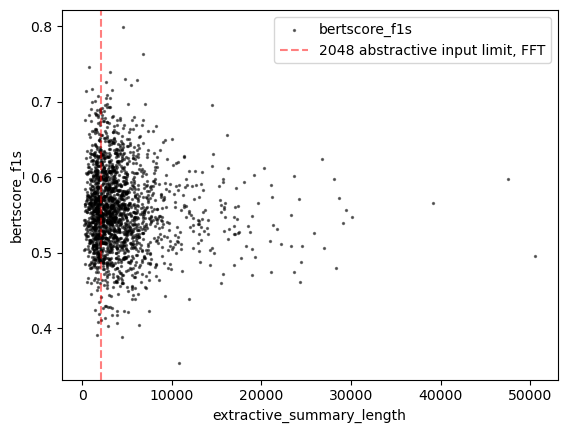

<Figure size 1000x500 with 0 Axes>

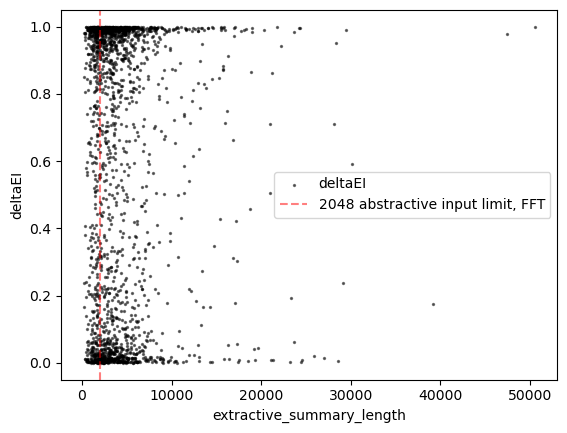

<Figure size 1000x500 with 0 Axes>

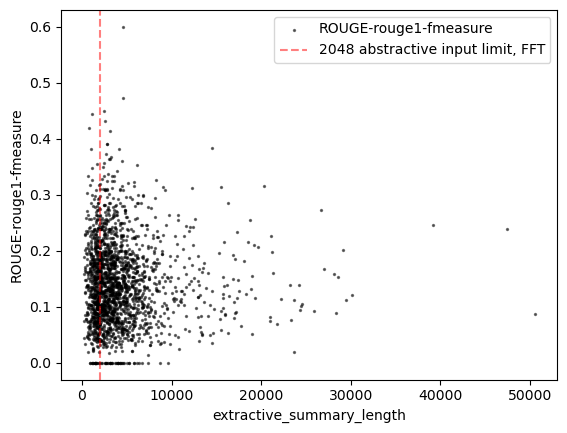

<Figure size 1000x500 with 0 Axes>

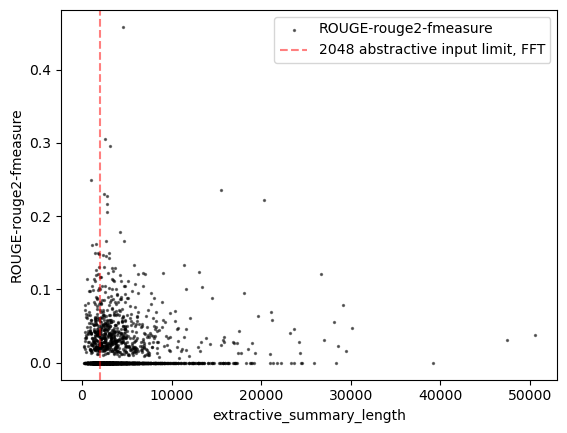

<Figure size 1000x500 with 0 Axes>

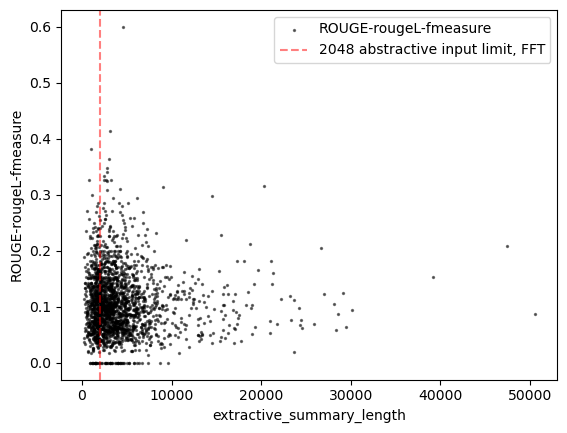

In [705]:
# Hypothesis: shorter input length truncates studies out

# # open "Baseline extractive BioBERT KMeans" dataset, calculate token length of each summary
# df_biobert_kmeans_val = pd.read_csv(df_model_info[df_model_info["model_name"] == "Baseline extractive BioBERT KMeans"]["generated_summaries_path"].iloc[0])  # validation data

# # batch tokenize summaries and target -- get length only!
# tokenizer = AutoTokenizer.from_pretrained("pszemraj/long-t5-tglobal-base-16384-book-summary")
# df_biobert_kmeans_val["summary_length"] = tokenizer.batch_encode_plus(df_biobert_kmeans_val["summary"].tolist(), return_length=True)["length"]

# # for each example, also find the corresponding generated summary in the "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input" dataset
# # add: abstractive_summary, abstractive_summary_length, metrics

model_to_investigate = "Experiment 4 BioBERT KMeans + LongT5, full fine-tuning, KMeans input"
_df_model4 = pd.read_csv(df_model_info[df_model_info["model_name"] == model_to_investigate]["generated_summaries_path"].iloc[0])
summary_col = df_model_info[df_model_info["model_name"] == model_to_investigate]["column_for_generated_text"].iloc[0]
df_biobert_kmeans_val["abstractive_summary"] = [_df_model4.iloc[_df_model4["review_id"].astype(str).tolist().index(str(docid))][summary_col] for docid in df_biobert_kmeans_val["review_id"]]
df_biobert_kmeans_val["abstractive_summary_length"] = tokenizer.batch_encode_plus(df_biobert_kmeans_val["abstractive_summary"].tolist(), return_length=True)["length"]

# transfer bertscore_f1s, deltaEI, rouge1, rouge2, rougeL from results[model]
df_biobert_kmeans_val["bertscore_f1s"] = [float(results[model_to_investigate]["bertscore_f1s"][_df_model4["review_id"].astype(str).tolist().index(str(docid))]) for docid in df_biobert_kmeans_val["review_id"]]
df_biobert_kmeans_val["deltaEI"] = [float(results[model_to_investigate]["evidence_inference_divergence"]["scores"][_df_model4["review_id"].astype(str).tolist().index(str(docid))]) for docid in df_biobert_kmeans_val["review_id"]]
df_biobert_kmeans_val["ROUGE-rouge1-fmeasure"] = [float(results[model_to_investigate]["ROUGE-rouge1-fmeasure"][_df_model4["review_id"].astype(str).tolist().index(str(docid))]) for docid in df_biobert_kmeans_val["review_id"]]
df_biobert_kmeans_val["ROUGE-rouge2-fmeasure"] = [float(results[model_to_investigate]["ROUGE-rouge2-fmeasure"][_df_model4["review_id"].astype(str).tolist().index(str(docid))]) for docid in df_biobert_kmeans_val["review_id"]]
df_biobert_kmeans_val["ROUGE-rougeL-fmeasure"] = [float(results[model_to_investigate]["ROUGE-rougeL-fmeasure"][_df_model4["review_id"].astype(str).tolist().index(str(docid))]) for docid in df_biobert_kmeans_val["review_id"]]

df_biobert_kmeans_val_renamed = df_biobert_kmeans_val.rename(
    columns={
        "summary": "extractive_summary",
        "summary_length": "extractive_summary_length",
    },
)

# plot metrics vs extractive summary length
for metric in ["bertscore_f1s", "deltaEI", "ROUGE-rouge1-fmeasure", "ROUGE-rouge2-fmeasure", "ROUGE-rougeL-fmeasure"]:
    fig = plt.figure(figsize=(10, 5))
    df_biobert_kmeans_val_renamed.plot.scatter(x="extractive_summary_length", y=metric, alpha=0.5, s=2, color="black", label=metric)
    # add cutoff line: 2048
    plt.axvline(2048, color="red", linestyle="--", label="2048 abstractive input limit, FFT", alpha=0.5)
    plt.legend()

In [695]:
_df_model4["review_id"].astype(str).tolist().index(str(28514886))

0

In [697]:
df_biobert_kmeans_val["review_id"]  #.tolist().index(28514886)

0       28514886
1       18842808
2       24297836
3       32367221
4       25038833
          ...   
2016    19776504
2017    27505198
2018    25251296
2019    23235652
2020    30058911
Name: review_id, Length: 2021, dtype: int64